<a id='index'></a>
##### Index
* <a href='#introduction'>Introduction</a>
* <a href='#data'>Processed data</a>
    * <a href='#data:load'>Data loading</a>
    * <a href='#data:visualization'>Data visualization</a>
    * <a href='#data:feature'>Feature selection</a>


* <a href='#model'>Model definition and hyperparameter optimization</a>
    * <a href='#model:cat_oc'>One Class classification models</a>
        * <a href='#model_oc:ocsvm'>One Class SVM</a>
        * <a href='#model_oc:AU'>One Class AutoEncoder</a>
        * <a href='#model_oc:...'>...</a>
        
    * <a href='#model:cat_binary'>Binary (supervised) classification models</a>
        * <a href='#model_binary:svm'>SVM</a>
        * <a href='#model_binary:AU'>Autoencoder</a>
        * <a href='#model_binary:...'>...</a>

        
* <a href='#results'>Results</a>
* <a href='#conclusions'>Conclusions</a>


    


<a href='#index'>...</a>
<a id='introduction'></a>
# Introduction

**Imports**

In [6]:
import pandas as pd
import sklearn
import numpy as np
import random
from scipy import stats

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

# Plot
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from prettytable import PrettyTable
sns.set()

# Configuration
from tqdm.notebook import tqdm
from tqdm import tnrange
import warnings
from ipywidgets import IntProgress
from IPython import display
import time
import os
import json
import copy

# Models
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from pyod.models import ocsvm, auto_encoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.base import clone

# Evaluation
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer, roc_curve, auc, plot_roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix


**Environment configuration**

In [2]:
def set_display_range(range_columns=pd.options.display.max_columns, range_rows=pd.options.display.max_rows, reset_columns=0, reset_rows=0):
    pd.set_option('display.max_columns', range_columns)
    pd.set_option('display.max_rows', range_rows)
    if (reset_columns): pd.reset_option('display.max_columns')
    if (reset_rows): pd.reset_option('display.max_rows')

set_display_range(range_columns=None, range_rows=10)

<a href='#index'>...</a>
<a id='data'></a>
# Processed data

<a id='data:load'></a>
## Data loading

![multistarts](media/multistart.png "multistarts")

In [3]:
root_folder_proc = '../OneClass/OneClass_'

# oc_42
df_oc42_X_train = pd.read_csv(root_folder_proc+'42/X_train_42.csv', sep=';')
df_oc42_X_test = pd.read_csv(root_folder_proc+'42/X_test_42.csv', sep=';')
df_oc42_Y_train = pd.read_csv(root_folder_proc+'42/y_train.csv', sep=';')
df_oc42_Y_test = pd.read_csv(root_folder_proc+'42/y_test.csv', sep=';')

# oc_89
df_oc89_X_train = pd.read_csv(root_folder_proc+'89/X_train_89.csv', sep=';')
df_oc89_X_test = pd.read_csv(root_folder_proc+'89/X_test_89.csv', sep=';')
df_oc89_Y_train = pd.read_csv(root_folder_proc+'89/y_train.csv', sep=';')
df_oc89_Y_test = pd.read_csv(root_folder_proc+'89/y_test.csv', sep=';')

# oc_101
df_oc101_X_train = pd.read_csv(root_folder_proc+'101/X_train_101.csv', sep=';')
df_oc101_X_test = pd.read_csv(root_folder_proc+'101/X_test_101.csv', sep=';')
df_oc101_Y_train = pd.read_csv(root_folder_proc+'101/y_train.csv', sep=';')
df_oc101_Y_test = pd.read_csv(root_folder_proc+'101/y_test.csv', sep=';')

# oc_151
df_oc151_X_train = pd.read_csv(root_folder_proc+'151/X_train_151.csv', sep=';')
df_oc151_X_test = pd.read_csv(root_folder_proc+'151/X_test_151.csv', sep=';')
df_oc151_Y_train = pd.read_csv(root_folder_proc+'151/y_train.csv', sep=';')
df_oc151_Y_test = pd.read_csv(root_folder_proc+'151/y_test.csv', sep=';')

# oc_223
df_oc223_X_train = pd.read_csv(root_folder_proc+'223/X_train_223.csv', sep=';')
df_oc223_X_test = pd.read_csv(root_folder_proc+'223/X_test_223.csv', sep=';')
df_oc223_Y_train = pd.read_csv(root_folder_proc+'223/y_train.csv', sep=';')
df_oc223_Y_test = pd.read_csv(root_folder_proc+'223/y_test.csv', sep=';')

In [4]:
target_df = [(df_oc42_Y_train, df_oc42_Y_test), (df_oc89_Y_train, df_oc89_Y_test), (df_oc101_Y_train, df_oc101_Y_test), (df_oc151_Y_train, df_oc151_Y_test), (df_oc223_Y_train, df_oc223_Y_test)]
content_df = [(df_oc42_X_train, df_oc42_X_test), (df_oc89_X_train, df_oc89_X_test), (df_oc101_X_train, df_oc101_X_test), (df_oc151_X_train, df_oc151_X_test), (df_oc223_X_train, df_oc223_X_test)]
ms = [42, 89, 101, 151, 189]

CORE_collection = {}
# CORE_collection structure: dictionary of (float) list
# # CORE_collection[@random_state] = list
# Example: 
# CORE_collection = {42: [1,2,3,4...], 89: [6,9,23,34,...], etc}

X_collection = {}
# X_collection structure: dictionary of (float)-list touple
# X_collection[@random_state] = (X_train_df, Y_train_df)

Y_collection = {}              
# Y_collection structure: dictionary of (float)-list touple
# Y_collection[@random_state] = (Y_train_df, Y_train_df)

for Y, X, RS in zip(target_df, content_df, ms):
    Y[0].loc[Y[0]['ED0DISWHY']==0.0]=-1
    Y[1].loc[Y[1]['ED0DISWHY']==0.0]=-1
    Y[0]['ED0DISWHY'] = Y[0]['ED0DISWHY'].astype("int64")
    Y[1]['ED0DISWHY'] = Y[1]['ED0DISWHY'].astype("int64")
    
    cX = {}
    cY = {}
    
    # Cast core as int
    cX[0] = X[0].astype({"CORE": int})
    cX[1] = X[1].astype({"CORE": int})
    
    # Add core to Y
    Y[0]['CORE'] = cX[0]['CORE']
    Y[1]['CORE'] = cX[1]['CORE']
    
    CORE_collection[RS] = (cX[0]['CORE'],cX[1]['CORE'])
    
    # Set core as index in X
    cX[0] = cX[0].set_index('CORE')
    cX[1] = cX[1].set_index('CORE')
    
    # Set core as index in Y
    cY[0] = Y[0].set_index('CORE')
    cY[1] = Y[1].set_index('CORE')
              
    X_collection[RS] = (cX[0], cX[1])
    Y_collection[RS] = (cY[0], cY[1])
    
X_data = pd.concat([X_collection[42][0], X_collection[42][1]],axis=0)
Y_data = pd.concat([Y_collection[42][0], Y_collection[42][1]],axis=0)


<a id='data:visualization'></a>
## Data visualization

### Function definition

In [5]:
def column_percentage(df, column, main_label):
    try:
        return len(df.loc[df[column]==main_label])/len(df)
    except:
        return -1

In [6]:
def plot_zero_relevance(df, columns, dim_x, dim_y, main_title='SAMPLE TITLE', titles=None, verbose=0):
    '''
    Prints histogram for every columns desired in a dataframe.
    
    Parameters.
    ------------
    df: Pandas Dataframe
        Data dataframe
        
    columns:  String[]
              Array containning the names of the desired columns
              
    dim_x: int
           Size of the x axis of plot grid. 
    
    dim_y: int
           Size of the y axis of plot grid.
           
    main_title: String
                Title of the figure.
                
    titles: String[]
            Array containing the subtitle of every plot.
    
    verbose: int
             1 to activate verbose mode. Otherwise, hide prints.
                
    '''
    col = 0
    total = df.shape[0]
    if (verbose) : print("Number of 0's:")
    if (titles == None) : titles=columns 
    fig, axes = plt.subplots(dim_x, dim_y, figsize=(16,8))
    fig.suptitle(main_title)
    try:
        for i in range(dim_x):
            for j in range(dim_y):
                if (verbose):
                    print("* "+titles[col]+" \t{} ({:.2f}%)".format(sum(df[columns[col]]==0),sum(df[columns[col]]==0)/total*100))
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    ax = sns.distplot(ax=axes[i,j], x=df[columns[col]], color='#388E3C') # hist=True
                if (ax.lines != []):
                    kde_x, kde_y = ax.lines[0].get_data()
                    ax.fill_between(kde_x, kde_y, where=(kde_x<max(df[columns[col]])*0.1), interpolate=True, color='#EF9A9A')
                axes[i,j].set_title(titles[col])  
                col+=1
    except:
        pass

In [7]:
def zero_relevance(df, columns):
    '''
    Prints 0 value percentage in defined columns.
    
    Parameters.
    ------------
    df: Pandas Dataframe
        Data dataframe
        
    columns:  String[]
              Array containning the names of the desired columns to print  
    '''
    print("Percentage of 0's per column:")
    total = df.shape[0]
    for col in columns:
        print("* "+col+" \t{} ({:.2f}%)".format(sum(df[col]==0),sum(df[col]==0)/total*100))
               

In [8]:
def plot_pair_individual(X, Y, x1, x2):
    '''
    Plots a pair-plot type grid axes for 2 features and one target.
    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    x1:  String
        Name of the first column
        
    x1:  String
        Name of the second column
    '''
    fig, ax = plt.subplots()
    index = Y.index
    normal_index = index[Y==1]
    anomaly_index = index[Y==-1]
    X_normal = X.loc[normal_index, :]
    X_anomaly = X.loc[anomaly_index, :]
    ax.scatter(X_anomaly[x1], X_anomaly[x2], c='plum', alpha=0.7, label='Anomaly samples')
    ax.scatter(X_normal[x1], X_normal[x2], c='rebeccapurple', alpha=0.7, label='Positive samples')
    plt.xlabel(x1)
    plt.ylabel(x2)
    leg = ax.legend()

In [9]:
def plot_kde(X, Y, col):
    '''    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    col:  String
        Name of the first column
    '''
    ax = plt.figure(figsize=(6, 4), dpi=80).gca()
    with pd.option_context('mode.chained_assignment',None):
        data = X.copy()
        y_copy = Y.copy()
        data['Class'] = y_copy['ED0DISWHY']
        data['Class'].loc[data['Class']==1] = 'Deceased'
        data['Class'].loc[data['Class']==-1] = 'Not deceased'

        sns.histplot(data=data, x=col, hue="Class", palette=sns.color_palette("CMRmap_r", n_colors=2), kde=True)

    plt.title(f'Feture {col}')
    ax.text(185, 20,'Text Here', fontsize=9) #add text
    plt.show()


In [10]:
def plot_joint(X, Y, columns, kind='scatter'):
    '''
    kind = { “scatter” | “kde” | “hist”}
    '''
    data = X.copy()
    data['Class'] = 0
    with pd.option_context('mode.chained_assignment',None):
        data['Class'].loc[Y['ED0DISWHY']==1] = 'Deceased'
        data['Class'].loc[Y['ED0DISWHY']==-1] = 'Not deceased'
        j = sns.jointplot(data=data, x=columns[0], y=columns[1], palette=sns.color_palette("CMRmap_r", n_colors=2),hue="Class", kind=kind)
    #     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

In [11]:
def plot_box_plot(X, Y, features, save=0):
    '''
    Plots plot-box type grid axes for 1 feature and one target.
    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    features: String[]
              Array containning the names of the desired columns to print
  
    save: int
            1 value, save plots. Otherwise, print plots.
    '''
    path = './boxplots'
    if (not os.path.isdir(path)):
        try:
            os.mkdir(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Successfully created the directory %s " % path)
    for feat in features:
        boxp = sns.boxplot(y=X[feat],x=Y['ED0DISWHY'])
        if (save):
            fig = boxp.get_figure()
            fig.savefig(path+'/bp_'+feat+'.png')
            plt.close()
        else:
            plt.show()

# plot_box_plot(X=X_collection[42][0], Y=Y_collection[42][0], features=X_collection[42][0].columns, save=1

### Visualization

**Pairwise representation of features, visualizing the relationship with the target class.**

Individual pairs.

In [11]:
plot_pair_individual(X_data, Y_data['ED0DISWHY'], 'CT0000LDH', 'CTHSDXXSAT')
plot_pair_individual(X_data, Y_data['ED0DISWHY'], 'CT0000NEU', 'CTHSDXXRATE')

Record features taken during admission and registered information about diagnosis and procedements (according to CIE10 codification).

Text(0.5, 1.08, "Positive/anomaly samples' features taken during admision and diagnosis/procedements values (according to CIE10 codification)")

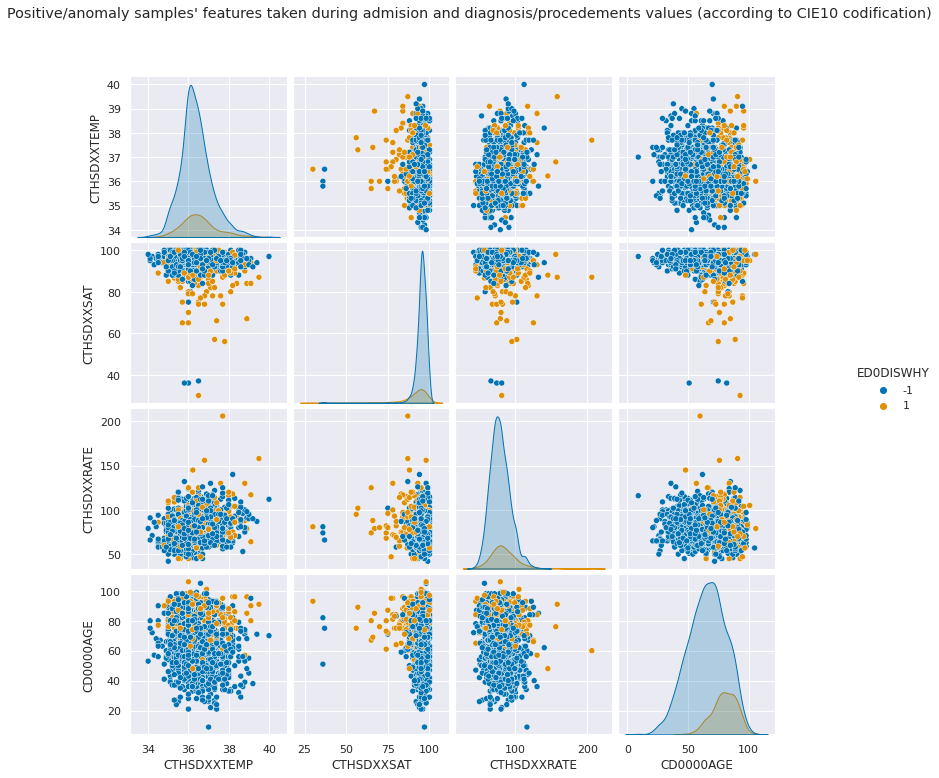

In [12]:
pp = sns.pairplot(pd.concat([X_data[['CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE', 'CD0000AGE']], Y_data],axis=1), hue='ED0DISWHY', palette='colorblind')
pp.fig.suptitle("Positive/anomaly samples' features taken during admision and diagnosis/procedements values (according to CIE10 codification)", y=1.08)

Distribution representation of features for positive and anomaly samples.


Distribution of features per class:

In [167]:
plot_kde(X_data, Y_data, 'CD0000AGE')

In [168]:
# ['CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE', 'CD0000AGE']
plot_joint(X_collection[42][0], Y_collection[42][0], ['CTHSDXXTEMP', 'CD0000AGE'], kind = 'kde')

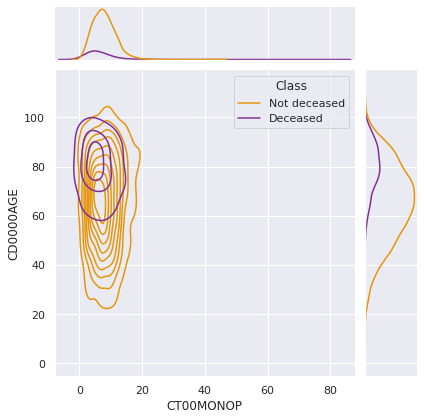

In [169]:
# ['CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE', 'CD0000AGE']
plot_joint(X_collection[42][0], Y_collection[42][0], ['CT00MONOP', 'CD0000AGE'], kind = 'kde')

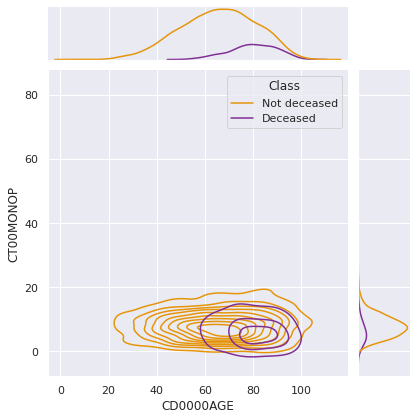

In [171]:
# ['CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE', 'CD0000AGE']
plot_joint(X_collection[42][0], Y_collection[42][0], ['CD0000AGE', 'CT00MONOP'], kind = 'kde')


<a id='data:feature'></a>
## Feature selection

### Ranking features based on variance (most to least)

In [ ]:
## Feature selection / filtering based on ranking features based on variance (from most [top1] to least [top last] variance)

columns = X_collection[42][0].columns.to_numpy()

## Keep columns that are not desired to remov
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 10

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

variance = {k: None for k in columns}
for universe in ms:
    remove = []
    print(f'Universe {universe} top variance:')
    for col in columns:
        var = X_collection[universe][0][col].var()
        variance[col] = var
    
    variance = {k: v for k, v in sorted(variance.items(), key=lambda item: item[1], reverse=True)}
#   print(f'Universe {universe} top variance:')
    for i, col in zip(range(len(variance)), variance): 
        print(f"{i+1}. {col}: {variance[col]:.3f}")
        
    variance_keys = list(variance.keys())
    
    X_collection[universe][0].drop(columns=variance_keys[total_columns-columns_to_drop:], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=variance_keys[total_columns-columns_to_drop:], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{variance_keys[-total_columns-columns_to_drop:]}\n')

### Ranking features based on MAD (most to least)

In [ ]:
## Feature selection / filtering based on ranking features based on MAD (from most [top1] to least [top last] variance)

columns = X_collection[42][0].columns.to_numpy()

## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 30

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

mad_list = {k: None for k in columns}
for universe in ms:
    remove = []
    print(f'Universe {universe} top variance:')
    for col in columns:
        mad = stats.median_abs_deviation(X_collection[universe][0][col])
        mad_list[col] = mad
    
    mad_list = {k: v for k, v in sorted(mad_list.items(), key=lambda item: item[1], reverse=True)}
#   print(f'Universe {universe} top variance:')
    for i, col in zip(range(len(mad_list)), mad_list): 
        print(f"{i+1}. {col}: {mad_list[col]:.3f}")
        
    mad_keys = list(mad_list.keys())
    
    X_collection[universe][0].drop(columns=mad_keys[total_columns-columns_to_drop:], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=mad_keys[total_columns-columns_to_drop:], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{mad_keys[total_columns-columns_to_drop:]}\n')

### Ranking features based on variance RATIO (most to least)

In [7]:
## Feature selection / filtering based on (variance_total % variance_positive) ratio 

columns = X_collection[42][0].columns.to_numpy()

## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 33

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

ratio = {k: None for k in columns}
for universe in ms:
    remove = []
    positive_index = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index

    for col in columns: 
        # Variance with normal and abnormal samples
        var = X_collection[universe][0][col].var()
        # Variance with normal samples
        var_pos = X_collection[universe][0].loc[positive_index, :][col].var()
        ratio_value = var/var_pos
        ratio[col] = ratio_value
    
    ratio = {k: v for k, v in sorted(ratio.items(), key=lambda item: item[1])}
#     print(f'Universe {universe} top variance:')
#     for i, col in zip(range(len(ratio)), ratio): 
#         print(f"{i+1}. {col}: {ratio[col]:.3f}")
    ratio_keys = list(ratio.keys())

    X_collection[universe][0].drop(columns=ratio_keys[total_columns-columns_to_drop:], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=ratio_keys[total_columns-columns_to_drop:], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{ratio_keys[total_columns-columns_to_drop:]}\n')

Number of columns to drop: 33

Original feature size: 44. New feature size: 11.

Removed features in universe 42:
['CT000LEUC', 'CT00000NA', 'CT000000U', 'CT00000DD', 'CT0000INR', 'CT00MONOP', 'CT000APTT', 'CT0000NEU', 'CT0000GLU', 'CTHSDXXRATE', 'CT0000PCR', 'CT0000COM', 'CT000000K', 'CT00000AP', 'CT0000VCM', 'CT000HCTO', 'CT0000ADW', 'CT0000HGB', 'CT0000HEM', 'CT0000VPM', 'CTHSDXXTEMP', 'CT000PLAQ', 'CT000CHCM', 'CT0000BAS', 'CT0000HCM', 'CT0000LIN', 'CT000NEUP', 'CT000LINP', 'CT0000GGT', 'CT0000SYM', 'CT000BASP', 'CT000EOSP', 'CT0000EOS']

Removed features in universe 89:
['CT0000LIN', 'CT000000U', 'CT00000TP', 'CT00000NA', 'CT00000DD', 'CT00MONOP', 'CT0000NEU', 'CT0000INR', 'CT0000GLU', 'CT000APTT', 'CTHSDXXRATE', 'CT0000PCR', 'CT000000K', 'CT00000AP', 'CT0000COM', 'CT0000VCM', 'CT0000ADW', 'CT000HCTO', 'CTHSDXXTEMP', 'CT0000HGB', 'CT0000HEM', 'CT000PLAQ', 'CT0000VPM', 'CT000CHCM', 'CT0000HCM', 'CT0000BAS', 'CT000NEUP', 'CT000LINP', 'CT0000GGT', 'CT000BASP', 'CT0000SYM', 'CT000EOSP

### Ranking features based on MAD RATIO (most to least)

In [ ]:
## Feature selection / filtering based on (variance_total % variance_positive) ratio 

columns = X_collection[42][0].columns.to_numpy()


## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 30

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

ratio = {k: None for k in columns}
for universe in ms:
    remove = []
    positive_index = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index

    for col in columns: 
        # Variance with normal and abnormal samples
        mad = stats.median_abs_deviation(X_collection[universe][0][col])
        # Variance with normal samples
        mad_pos = stats.median_abs_deviation(X_collection[universe][0].loc[positive_index, :][col])

        # Avoid divide by 0
        ratio_value = mad/mad_pos if mad_pos>0 else mad/0.00001
        ratio[col] = ratio_value
    
    ratio = {k: v for k, v in sorted(ratio.items(), key=lambda item: item[1])}
    
#     Print TOP features per universe
#     print(f'Universe {universe} top MAD:')
#     for i, col in zip(range(len(ratio)), ratio): 
#         print(f"{i+1}. {col}: {ratio[col]:.7f}")
    ratio_keys = list(ratio.keys())

    X_collection[universe][0].drop(columns=ratio_keys[1*(total_columns-columns_to_drop):], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=ratio_keys[1*(total_columns-columns_to_drop):], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{ratio_keys[total_columns-columns_to_drop:]}\n')

<a href='#index'>...</a>
<a id='model'></a>
# Model definition and hyperparameter optimization

## Function definition

### ToolsVisualization

In [1]:
class ToolsVisualization:
    def __init__(self):
        self._tool = ToolsClassification()
    
    def outlierness_supervised(self, y_true, outlier_score, normal=1, anomaly=-1, threshold=-1): 
        # Visualize outlier-score (SUPERVISED WAY)
        for i in outlier_score:
            ax = plt.figure(figsize=(14, 4), dpi=80).gca()
            plt.title(f'Outlierness of Universe {i}')

            positive_index = y_true[i][1].loc[y_true[i][1]['ED0DISWHY']==normal].index
            anomaly_index = y_true[i][1].loc[y_true[i][1]['ED0DISWHY']==anomaly].index

            sns.stripplot(x=outlier_score[i][anomaly_index], alpha = .4, edgecolor = 'none', color = 'darkblue', label='Anomaly', ax = ax)
            plt.axvline(x=outlier_score[i][anomaly_index].median(), ymin=0.25, ymax=0.75, color = 'darkblue', linestyle='-', alpha=0.7)
            sns.stripplot(x=outlier_score[i][positive_index], alpha = .8, edgecolor = 'black', color='red', label='Positive', ax = ax)
            plt.axvline(x=outlier_score[i][positive_index].median(), ymin=0.25, ymax=0.75, color='red', linestyle='-', alpha=0.7)

            if (threshold != -1):  plt.axvline(x=threshold, color='g', linestyle='-')
            plt.legend()
            plt.show()
        #     plt.xticks(np.arange(min(outlierness_dict[universe]), max(outlierness_dict[universe])+1, 1.0))
        
    
    def outlierness_unsupervised(self, outlier_score, normal=1, anomaly=-1, quantile = -1, title = 'Outlierness of Universe '): 
    # Visualize outlier-score (UNSUPERVISED WAY)
        for i in outlier_score:
            ax = plt.figure(figsize=(14, 4), dpi=80).gca()
            plt.title(f'{title}{i}')

            if (quantile != -1):  
                q = outlier_score[i].quantile(quantile)
                low_q = outlier_score[i].loc[outlier_score[i]<q]
                high_q = outlier_score[i].loc[outlier_score[i]>=q]
                sns.stripplot(x=low_q, ax = ax, color='blue', label = f'Lower than quantile {quantile}')
                sns.stripplot(x=high_q, ax = ax, color='orange', label = f'Higher than quantile {quantile}')
                plt.axvline(x=q, color='g', linestyle='-', label=f'Quantile {quantile}: ~{q:.6}')
                plt.legend()
            else:
                sns.stripplot(x=outlier_score[i], ax = ax)

    #         plt.xticks(np.arange(min(outlier_score[universe]), max(outlier_score[universe])+1, 1.0))
    
    def confusion_matrix_plot(self, y_true, y_pred, labels, normal, anomaly, rs='UNDEFINED'):

        array = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)

        df_cm = pd.DataFrame({normal: array[:,0], anomaly: array[:,1]}, index=[normal, anomaly])

        total = df_cm[normal].sum()+df_cm[anomaly].sum()

        df_cm_p = df_cm.applymap(str)
        df_cm_p[normal][normal] = df_cm_p[normal][normal]+'\n'+"{:.2f}".format(df_cm[normal][normal]/total*100)+'%'
        df_cm_p[normal][anomaly] = df_cm_p[normal][anomaly]+'\n'+"{:.2f}".format(df_cm[normal][anomaly]/total*100)+'%'
        df_cm_p[anomaly][normal] = df_cm_p[anomaly][normal]+'\n'+"{:.2f}".format(df_cm[anomaly][normal]/total*100)+'%'
        df_cm_p[anomaly][anomaly] = df_cm_p[anomaly][anomaly]+'\n'+"{:.2f}".format(df_cm[anomaly][anomaly]/total*100)+'%'

        plt.figure(figsize=(8,5))
        plt.title('Confusion matrix of universe {}'.format(rs))
        sns.heatmap(df_cm, annot=df_cm_p, fmt='', annot_kws={"size": 15}) # font size
        plt.ylabel("Ground truth")
        plt.xlabel("Predicted") 

        plt.show()
    
    def confusion_matrix_plot_total(self, y_true, y_pred, labels, normal, anomaly):
    
        fig, axs = plt.subplots(3,2, figsize=(20, 20))
        axs_flat = axs.flat[:-1]
        axs[-1, -1].axis('off')
        for i, ax in enumerate(axs_flat):
            universe = [*y_true][i]

            array = confusion_matrix(y_true=y_true[universe][1], y_pred=y_pred[universe], labels=labels)

            df_cm = pd.DataFrame({normal: array[:,0], anomaly: array[:,1]}, index=[normal, anomaly])

            total = df_cm[normal].sum()+df_cm[anomaly].sum()

            df_cm_p = df_cm.applymap(str)
            df_cm_p[normal][normal] = df_cm_p[normal][normal]+'\n'+"{:.2f}".format(df_cm[normal][normal]/total*100)+'%'
            df_cm_p[normal][anomaly] = df_cm_p[normal][anomaly]+'\n'+"{:.2f}".format(df_cm[normal][anomaly]/total*100)+'%'
            df_cm_p[anomaly][normal] = df_cm_p[anomaly][normal]+'\n'+"{:.2f}".format(df_cm[anomaly][normal]/total*100)+'%'
            df_cm_p[anomaly][anomaly] = df_cm_p[anomaly][anomaly]+'\n'+"{:.2f}".format(df_cm[anomaly][anomaly]/total*100)+'%'

            sns.heatmap(df_cm, annot=df_cm_p,ax=ax, fmt='', annot_kws={"size": 15}) # font size
            ax.set_ylabel('Ground truth')
            ax.set_xlabel('Predicted')
            ax.set_title('Confusion matrix of universe {}'.format(universe))
 
    def ROC_plot_total(self, y_true, outlier_score, normal):
    
        fig, axs = plt.subplots(3,2, figsize=(20, 20))
        axs_flat = axs.flat[:-1]
        axs[-1, -1].axis('off')
        for i, ax in enumerate(axs_flat):
            universe = [*y_true][i]
            norm_outlier_score = self._tool.normalize(outlier_score[universe])
            fpr, tpr, thresholds = roc_curve(y_true[universe][1], norm_outlier_score, pos_label=normal)
            roc_auc = auc(fpr, tpr)

            ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            ax.legend(loc = 'lower right')
            ax.plot([0, 1], [0, 1],'r--')
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 1])
            ax.set_ylabel('True Positive Rate')
            ax.set_xlabel('False Positive Rate')
            ax.set_title('Receiver Operating Characteristic {}'.format(universe))
 
    def precision_recall_plot_total(self, y_true, outlier_score, normal):
        fig, axs = plt.subplots(3,2, figsize=(20, 20))
        axs_flat = axs.flat[:-1]
        axs[-1, -1].axis('off')
        for i, ax in enumerate(axs_flat):
            universe = [*y_true][i]
            norm_outlier_score = self._tool.normalize(outlier_score[universe])
            precision, recall, thresholds = precision_recall_curve(y_true[universe][1], norm_outlier_score, pos_label=normal)
            p_r_auc = auc(recall, precision)
       
            ax.plot(precision, recall, 'b', label = 'AUC = %0.2f' % p_r_auc)
            ax.legend(loc = 'lower right')
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 1])
            ax.set_ylabel('Precision')
            ax.set_xlabel('Recall')
            ax.set_title('Precision-Recall curve {}'.format(universe))
    
    def outlierness_plot_total(self, y_true, y_pred, outlier_score, normal, anomaly, xlim0=-1, xlim1=-1): 
    # Visualization of the outlierness distribution
        fig, axs = plt.subplots(4,1, figsize=(10, 40))
        axs_flat = axs.flat

        for i, ax in enumerate(axs_flat):
            universe = [*y_true][i]

            gt_positive_index = y_true[universe][1].loc[y_true[universe][1]['ED0DISWHY']==normal].index
            gt_negative_index = y_true[universe][1].loc[y_true[universe][1]['ED0DISWHY']==anomaly].index

            p_positive_index = y_pred[universe].loc[y_pred[universe]==normal].index
            p_negative_index = y_pred[universe].loc[y_pred[universe]==anomaly].index

            true_positive_index = gt_positive_index.intersection(p_positive_index)
            false_negative_index = gt_positive_index.intersection(p_negative_index)

            true_negative_index = gt_negative_index.intersection(p_negative_index)
            false_positive_index = gt_negative_index.intersection(p_positive_index)

            d = {'Outlier-score':outlier_score[universe][true_positive_index], 'Classification':len(outlier_score[universe][true_positive_index])*['True Positive']}
            df_true_positive = pd.DataFrame(data=d)
            d = {'Outlier-score':outlier_score[universe][false_positive_index], 'Classification':len(outlier_score[universe][false_positive_index])*['False Positive']}
            df_false_positive = pd.DataFrame(data=d)
            d = {'Outlier-score':outlier_score[universe][true_negative_index], 'Classification':len(outlier_score[universe][true_negative_index])*['True Negative']}
            df_true_negative = pd.DataFrame(data=d)
            d = {'Outlier-score':outlier_score[universe][false_negative_index], 'Classification':len(outlier_score[universe][false_negative_index])*['False Negative']}
            df_false_negative = pd.DataFrame(data=d)

            df_scores = pd.concat([df_true_positive, df_false_positive, df_true_negative, df_false_negative])

            plt.title('Outlierness distribution')
            if (xlim0!=-1 and xlim1!=-1):
                plt.xlim([xlim0, xlim1])
            sns.boxplot(y='Classification', x='Outlier-score', data=df_scores, whis=np.inf, ax=ax)
            sns.stripplot(y='Classification', x='Outlier-score', data=df_scores, color=".25", ax=ax)


    

### ToolsClassification

In [4]:
class ToolsClassification:
    def __init__(self):
        pass
    
    def metric_evaluation(self, y_true, y_pred, outlier_score, pos_label):
        cm = {}
        evaluations = pd.DataFrame(columns=['AUC', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1-score'])
        for universe in y_true:
            # Confusion matrix calculation
            array = confusion_matrix(y_true=y_true[universe][1], y_pred=y_pred[universe], labels=[pos_label,-pos_label])
            cm[universe]=(' {} {}\n{} {}'.format(array[0,0], array[0,1], array[1,0], array[1,1]))

            # Metric calculation
            # AUC, Accuracy, Precision, Sensitivity, Specifity, F1-score
            norm_outlier_score = self.normalize(outlier_score[universe])
            fpr, tpr, thresholds = roc_curve(y_true[universe][1], norm_outlier_score, pos_label=pos_label)
            roc_auc = auc(fpr, tpr)
            met = [roc_auc,\
                   accuracy_score(y_true = y_true[universe][1],y_pred = y_pred[universe]),\
                   precision_score(y_true = y_true[universe][1],y_pred = y_pred[universe]),\
                   recall_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=pos_label),\
                   recall_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=-pos_label),\
                   f1_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=pos_label)]

            evaluations.loc[universe] = met

        pt = PrettyTable()
        pt.field_names = ["Prediction"]+['Pos Neg [{}]'.format(x) for x in ms]
        pt.add_row(['Positive\nNegative']+list(cm.values()))
        pt.add_row(6*['---------------'])
        for metric in evaluations.columns:
            formated_ev = ["{:.3f}".format(x) for x in evaluations[metric]]
            max_i = np.argmax(evaluations[metric])
            formated_ev[max_i] = formated_ev[max_i]+'*'
            pt.add_row([metric]+formated_ev)

        pt.align['Prediction']='l'
        print(pt)

        return evaluations
    
    def normalize(self, arr):
        return (arr-min(arr))/(max(arr)-min(arr))
    
    def oc_split(self, Y, train, test, normal):
        indexed_train = zip(np.arange(0,train.shape[0],1), train)
        # Index to remove from train set
        del_index = []

        for train_index, df_index in indexed_train: 
            sample = Y.iloc[df_index]
            if (sample['ED0DISWHY']!=normal):
                # Append anomaly samples from train to test
                test = np.append(test, df_index)
                # Update train (anomaly) indexes
                del_index.append(train_index)
        # Remove anomaly samples from train
        train = np.delete(train, del_index, 0)
        return train, test
    
    def nested_cv(self, X, Y, outer_folds, inner_folds, model, parameters, score, normal_target):

        outer_loop=1
        max_score = -1
        score_outer = []
        inner_results = []

        # Define outer-loop
        skfold_outer = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=1)
        for train_outer, test_outer in skfold_outer.split(X, Y):

            print("Outer loop folds: {}/{}".format(outer_loop, outer_folds))

            # Outer-loop data retrieve
            X_train_outer, X_test_outer = X.iloc[train_outer], X.iloc[test_outer]
            Y_train_outer, Y_test_outer = Y.iloc[train_outer], Y.iloc[test_outer]

            # Define inner loop
            skfold_inner = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=1)

            # Transfering anomaly samples from train to test subsets.

            skfold_inner_cv = list()
            for train_inner, test_inner in skfold_inner.split(X_train_outer, Y_train_outer):
                # List containing indexes with train subset clear of anomaly samples
                skfold_inner_cv.append((self.oc_split(Y, train_inner, test_inner, normal_target)))

            # GRIDSEARCH
            # Obtain best model
            scorer = make_scorer(score, pos_label=normal_target)

            gsearch = GridSearchCV(model, param_grid=parameters, cv=skfold_inner_cv, scoring=scorer)
            gsearch.fit(X.iloc[train_outer], Y.iloc[train_outer])
            inner_results.append(gsearch.cv_results_)

            # Best estimator
            estimator = gsearch.best_estimator_
            pred_y = estimator.predict(X_test_outer)

            score_val = score(y_true=Y.iloc[test_outer],y_pred= pred_y, pos_label=normal_target)
            score_outer.append(score_val)
            if (score_val>=max(score_outer)): best_estimator = estimator

            outer_loop+=1

        print("Metrics: f1-score")
        print("Summary:")
        for i in range(outer_folds):
            best_ifold = np.where(inner_results[i]['rank_test_score'] == 1)[0][0]
            print("Outer fold nº{}.".format(i+1))
            print("Parameters (best of cv): {}".format(inner_results[i]['params'][best_ifold]))
            print("Score (best of cv): {:.3}±{:.2}".format(inner_results[i]['mean_test_score'][best_ifold], inner_results[i]['std_test_score'][best_ifold]))
            print("Score (outer): {:.4}\n".format(score_outer[i]))
        return best_estimator
        

<a id='model:cat_oc'></a>
## One Class classification models

TODO: EXPLANATION

<a id='model_oc:ocsvm'></a>
## Boundary based methods: One-Class SVM (OCSVM)
Original paper.

[source](https://www.is.mpg.de/publications/815)

Original author related paper.

[source](https://ieeexplore.ieee.org/book/6267332)

TODO: EXPLANATION
- MODEL
    - Parameters
        - Nu is the parameter that controls the training errors (and the number of SVs). This parameter is always within the range (0,1].
        - Gamma parameter determines the influence of radius on the kernel. The range of this parameter depends on your data and application.
        
        ![Medium](https://miro.medium.com/max/554/1*2uaESizmfcjljwNIs6Nm9w.png)
        Source: [Medium](https://medium.com/@mail.garima7/one-class-svm-oc-svm-9ade87da6b10)
    
- OUTLIERNESS

## Reconstruction based methods: Autoencoder

TODO: EXPLANATION

## Density based methods: Local Outlier Factor (LOF)

TODO: EXPLANATION

# Pipeline definition


Steps of the pipeline:

 \# todo
 
 \# todo
 
 \# todo
 
 \# ...

In [8]:
class Pipeline:
    def __init__(self, classifier, data_X, data_Y, feature_keep = [], f_filter = 'var_ratio', f_perf = 'med_mean', parameters = {}):
        self._X = {}
        self._Y = {}
        self._params_raw = parameters
        
        for universe in data_X:
            x0 = data_X[universe][0].copy(deep=True) #pd.DataFrame(columns = data_X[universe][0].columns, data = copy.deepcopy(data_X[universe][0].values), index = data_X[universe][0].index)
            x1 = data_X[universe][1].copy(deep=True) #pd.DataFrame(columns = data_X[universe][1].columns, data = copy.deepcopy(data_X[universe][1].values), index = data_X[universe][1].index)
            
            y0 = data_Y[universe][0].copy(deep=True) #pd.DataFrame(columns = data_Y[universe][0].columns, data = copy.deepcopy(data_Y[universe][0].values), index = data_Y[universe][0].index)
            y1 = data_Y[universe][1].copy(deep=True) #pd.DataFrame(columns = data_Y[universe][1].columns, data = copy.deepcopy(data_Y[universe][1].values), index = data_Y[universe][1].index)

            self._X[universe] = (x0, x1)
            self._Y[universe] = (y0, y1)

        self._cl = classifier
        self._fil = f_filter
        self._fil_perf = f_perf
        self._tool = ToolsClassification()
        self._vis = ToolsVisualization()
        
        
        self._params = {}
            
        self._cl_dict = {}
        
        ################ A priori knowledge ################
            ## Keep columns that are not desired to remove

            # Todo: add summary per each feature

        self._keep = feature_keep
        
#         self.
        # ['var', 'mad', 'var_ratio', 'mad_ratio']
        
    def __repr__(self):
        return f"Pipeline \n\
                 X: ({len(self._X)},{len(self._X[42])}) \n\
                 Y: ({len(self._Y)},{len(self._Y[42])}) \n\
                 Classifier: {self._cl} \n\
                 Filtering: {self._fil}"
    
    def __str__(self):
        return self.__repr__()
    
    def process_outlierness(self, score):
        if (str(self._cl) == 'OneClassSVM()'):
            # Process outlier-score or outlierness:
            # Lower the score, lower the likelihood of being outlier.
            # Higher the score, higher the likelihood of being outlier.
            MIN = min(-score)
            outlier_score = -score - MIN
        if (('AutoEncoder' in str(self._cl)) or ('LOF' in str(lof.LOF()))):
            outlier_score = score
        else:
            return
        return outlier_score
        
    
    def feature_filtering(self, n_drop = 35):
        
#         display.clear_output(wait=True)
        print('\n # Applying feature filtering:')
    
        # Print characteristics
        print(f'\t Filtering mode: {self._fil}')
        print(f'\t Outcome quality measure metric: {self._fil_perf}')
        apply = self._fil_perf
        # apply = ['med', 'med_mean', 'auc']
        
        if self._fil in ['var', 'mad', 'var_ratio', 'mad_ratio']:
            best_difference = 0
            best_mean_difference = 0
            best_auc = 0

            ################ Feature filtering ################
            ## Based on (variance_total % variance_positive) ratio
            columns = self._X[42][0].columns.to_numpy()
            columns = np.setdiff1d(columns, self._keep)
            total_columns = len(self._X[42][0].columns) - len(self._keep)

            for universe in self._X:
                skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
                for train_outer, test_outer in tqdm(skfold.split(self._X[universe][0], self._Y[universe][0]), total=skfold.get_n_splits(), desc="k-fold"):

                    x_train_universe = self._X[universe][0].iloc[train_outer].copy()
                    y_train_universe = self._Y[universe][0].iloc[train_outer].copy()
                    x_test_universe = self._X[universe][0].iloc[test_outer].copy()
                    y_test_universe = self._Y[universe][0].iloc[test_outer].copy()
                    
                    positive_index = y_train_universe.loc[y_train_universe['ED0DISWHY']==1].index
                    
                    variance = {k: None for k in columns}
                    mad_list = {k: None for k in columns}
                    ratio = {k: None for k in columns}
                    
                    # Calculate statistics per columns
                    for col in columns:
                        # Variance
                        var = x_train_universe[col].var()
                        variance[col] = var
                        # Variance with normal samples
                        var_pos = x_train_universe.loc[positive_index, :][col].var()
                        # Mad
                        mad = stats.median_abs_deviation(x_train_universe[col])
                        mad_list[col] = mad
                        # Mad with normal samples
                        mad_pos = stats.median_abs_deviation(x_train_universe.loc[positive_index, :][col])

                        if (self._fil == 'var_ratio'):
                            ratio_value = var/var_pos
                            ratio[col] = ratio_value
                        elif (self._fil == 'mad_ratio'):
                            ratio_value = mad/mad_pos if mad_pos>0 else mad/0.00001
                            ratio[col] = ratio_value
                            
                    # Sort samples per statistics
                    if (self._fil == 'var_ratio' or self._fil == 'mad_ratio'):
                        ratio = {k: v for k, v in sorted(ratio.items(), key=lambda item: item[1])}
                        ratio_keys = list(ratio.keys())

                    variance = {k: v for k, v in sorted(variance.items(), key=lambda item: item[1], reverse=True)}
                    variance_keys = list(variance.keys())

                    mad_list = {k: v for k, v in sorted(mad_list.items(), key=lambda item: item[1], reverse=True)}
                    mad_keys = list(mad_list.keys())
                    
                    ################ Feature removal ################
                    total_difference = {k: 0 for k in range(0,n_drop)}
                    for columns_to_drop in tqdm(range(0,n_drop), desc = 'Feature filtering', leave = False): 
                        
                        if (self._fil == 'var'):
                            x_train = x_train_universe.drop(columns=variance_keys[total_columns-columns_to_drop:], axis=1).copy()#, inplace = True)
                            x_test = x_test_universe.drop(columns=variance_keys[total_columns-columns_to_drop:], axis=1).copy()#, inplace = True)
                        elif (self._fil == 'mad'):
                            x_train = x_train_universe.drop(columns=mad_keys[total_columns-columns_to_drop:], axis=1).copy()#, inplace = True)
                            x_test = x_test_universe.drop(columns=mad_keys[total_columns-columns_to_drop:], axis=1).copy()#, inplace = True)
                        else:
                            x_train = x_train_universe.drop(columns=ratio_keys[1*(total_columns-columns_to_drop):], axis=1).copy()#, inplace = True)
                            x_test = x_test_universe.drop(columns=ratio_keys[1*(total_columns-columns_to_drop):], axis=1).copy()#, inplace = True)
                
                        ########################## Fitting the model ################################
                        index_normal = y_train_universe.loc[y_train_universe['ED0DISWHY']==1].index
                        self._cl.fit(x_train.loc[index_normal, :])

                        # Predict unproccessed outlier-score
                        decision_function = self._cl.decision_function(x_test)
                        
                        # Process outlier-score or outlierness:
                        # Lower the score, lower the likelihood of being outlier.
                        # Higher the score, higher the likelihood of being outlier.
                        outlier_score = self.process_outlierness(decision_function)
                        outlier_score = pd.Series(outlier_score, index = x_test.index)

                        positive_index = y_test_universe.loc[y_test_universe['ED0DISWHY']==1].index
                        anomaly_index = y_test_universe.loc[y_test_universe['ED0DISWHY']==-1].index

                        norm_outlier_score = self._tool.normalize(outlier_score)

                        positive_median = norm_outlier_score[positive_index].median()
                        anomaly_median = norm_outlier_score[anomaly_index].median()
                        # OLD
            #             difference = abs(positive_median-anomaly_median)
                        # NEW
                        difference = anomaly_median - positive_median

                        fpr, tpr, thresholds = roc_curve(y_test_universe, norm_outlier_score, pos_label=1)
                        roc_auc = auc(fpr, tpr)

                        # CHECK FOR BEST OUTCOME
                        if (roc_auc > best_auc):
                            best_auc = roc_auc
                            best_feature_n_auc = columns_to_drop

                        if (positive_median<anomaly_median and difference>best_difference):
                              best_difference = difference
                              best_feature_n = columns_to_drop

                        total_difference[columns_to_drop] += difference

                    mean_difference = [total_difference[n]/5 for n in range(0,n_drop)]
                    feat_drop = np.argmax(mean_difference)
                    if (max(mean_difference) > best_mean_difference):
                          best_mean_difference = max(mean_difference)
                          best_feature_n_mean = feat_drop

            print(f'Best configuration (median difference):\n \t * Difference: {best_difference} \n \t * Filtering: {self._fil} \n \t * Removed features: {best_feature_n}')
            print(f'Best configuration (median difference) (mean universe):\n \t * Difference: {best_mean_difference} \n \t * Filtering: {self._fil} \n \t * Removed features: {best_feature_n_mean}')
            print(f'Best configuration (AUC):\n \t * AUC: {best_auc}  \n \t * Filtering: {self._fil} \n \t * Removed features: {best_feature_n_auc}') 
            
            ########### Apply filtering with best configuration ###########
            if (apply in ['med', 'med_mean', 'auc']):
                if apply == 'med':
                    n_col = best_feature_n
                elif apply == 'med_mean':
                    n_col = best_feature_n_mean
                else:
                    n_col = best_feature_n_auc
    
                for universe in self._X:
                    positive_index = self._Y[universe][0].loc[self._Y[universe][0]['ED0DISWHY']==1].index
                    for col in columns:
                        # Variance
                        var = self._X[universe][0][col].var()
                        variance[col] = var
                        # Variance with normal samples
                        var_pos = self._X[universe][0].loc[positive_index, :][col].var()
                        # Mad
                        mad = stats.median_abs_deviation(self._X[universe][0][col])
                        mad_list[col] = mad
                        # Mad with normal samples
                        mad_pos = stats.median_abs_deviation(self._X[universe][0].loc[positive_index, :][col])

                        if (self._fil == 'var_ratio'):
                            ratio_value = var/var_pos
                            ratio[col] = ratio_value
                        elif (self._fil == 'mad_ratio'):
                            ratio_value = mad/mad_pos if mad_pos>0 else mad/0.00001
                            ratio[col] = ratio_value
                            
                    if (self._fil == 'var_ratio' or self._fil == 'mad_ratio'):
                        ratio = {k: v for k, v in sorted(ratio.items(), key=lambda item: item[1])}
                        keys = list(ratio.keys())
                    
                    elif (self._fil == 'var'):
                        variance = {k: v for k, v in sorted(variance.items(), key=lambda item: item[1], reverse=True)}
                        keys = list(variance.keys())
                    else:
                        mad_list = {k: v for k, v in sorted(mad_list.items(), key=lambda item: item[1], reverse=True)}
                        keys = list(mad_list.keys())
    
                    self._X[universe][0].drop(columns=keys[total_columns-n_col:], axis = 1, inplace = True)
                    self._X[universe][1].drop(columns=keys[total_columns-n_col:], axis = 1, inplace = True)
            
                print(f'Filtering applied. {n_col} columns removed based on {self._fil}. Performace measured with {apply}.')
        else:
            print(f'Choosed filter method not valid. Should be one of the next options:',  ['var', 'mad', 'var_ratio', 'mad_ratio'])
    
    def row_removal(self, quantile=0.9, visual = False):
#         display.clear_output(wait=True)
        print('\n # Applying row removal:')
        print(f'\t Quantile (removal): {quantile}')
        # Positive train - Positive test
        # Detect local outliers inside train
        fold = random.randint(0,5)
        for universe in self._X:
            skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
            i = 0
            outlierness_dict = {}
            remove_index = np.array([])
            for train_outer, test_outer in tqdm(skfold.split(self._X[universe][0], self._Y[universe][0]), total=skfold.get_n_splits(), desc=f'Universe {universe}'):

                x_train_universe = self._X[universe][0].iloc[train_outer].copy()
                y_train_universe = self._Y[universe][0].iloc[train_outer].copy()
                x_test_universe = self._X[universe][0].iloc[test_outer].copy()
                y_test_universe = self._Y[universe][0].iloc[test_outer].copy()

                ## Leave test data uniquely with positive samples
                positive_index = y_test_universe.loc[y_test_universe['ED0DISWHY']==1].index

                X_positive_test = x_test_universe.loc[positive_index,]
                Y_positive_test = y_test_universe.loc[positive_index,]

                # Fit model with train data
                index_normal = y_train_universe.loc[y_train_universe['ED0DISWHY']==1].index
                self._cl.fit(x_train_universe.loc[index_normal, :])

                # Predict unproccessed outlier-score ON POSITIVE SAMPLES
                decision_function = self._cl.decision_function(X_positive_test)

                outlier_score = self.process_outlierness(decision_function)
                outlierness_dict[i] = pd.Series(outlier_score, index = X_positive_test.index)
                
                # Removing rows with outlierness higher than quantile x in every universe (per fold)
                # Remove local outliers from current fold in universe X from train of universe X
                rindex = outlierness_dict[i].loc[outlierness_dict[i]>outlierness_dict[i].quantile(0.9)]
                remove_index = np.concatenate([remove_index, rindex.index.tolist()])
                
                # Visualization
                if (visual and universe == 42 and fold == i):
                    self._vis.outlierness_unsupervised(outlier_score = outlierness_dict, quantile=quantile, title='Outlierness (universe 42). Fold: ')
                
                i+=1
                
            # Removing rows
            self._X[universe][0].drop(remove_index, inplace = True)
            self._Y[universe][0].drop(remove_index, inplace = True)

                
                
        time.sleep(2)
        
        return outlierness_dict
    
    def hyperparameter_optimization(self, outer_folds = 5, inner_folds = 5):
#         display.clear_output(wait=True)
        print('\n # Optimizing hyperparameters: ')
        print(f'\t Parameters to optimize: {str(list(self._params.keys()))[1:-1]}')
        if (self._params_raw != {}):
            for i in tqdm(self._X, total = len(self._X), desc = 'Hyperparameter optimization'):
                # Obtain model with best hyperparameters
                estimator = self._tool.nested_cv(self._X[i][0], self._Y[i][0], outer_folds, inner_folds, model= clone(pl._cl), parameters=self._params_raw, score=f1_score, normal_target = 1)
                self._params[i] = estimator.get_params()

    def fit(self):
#         display.clear_output(wait=True)
        print('\n # Fitting data...')
        for i in tqdm(self._X, total = len(self._X), desc = 'Classifier fitting'):
            self._cl_dict[i] = clone(self._cl)
            if (self._params != {}): 
                self._cl_dict[i].set_params(**self._params[i])
            pos_index = self._Y[i][0].loc[self._Y[i][0]['ED0DISWHY']==1].index
            train_positive = self._X[i][0].loc[pos_index, :]

            self._cl_dict[i].fit(train_positive)
            
    def outlierness(self, visual = False):
#         display.clear_output(wait=True)
#         print('\n########### OUTLIERNESS ###########\n')
        print('\n # Processing outlierness...')
        outlierness_dict = {}
        for i in self._X:
            decicision_function = self._cl_dict[i].decision_function(self._X[i][1])
                
            outlier_score = self.process_outlierness(decicision_function)
            outlierness_dict[i] = pd.Series(outlier_score, index = self._X[i][1].index)  
            
        if (visual):
            self._vis.outlierness_unsupervised(outlier_score = outlierness_dict)
            
        return outlierness_dict
            
            
    def predict(self, method = 'ROC', cutoff_list = '0'):
        
        print('\n # Predicting labels:')
        print(f'\t Cutoff value selection method: {method}')
        
        prediction = {}
        
        outlier_score = self.outlierness()
        for i in self._X:
            norm_outlier_score = self._tool.normalize(outlier_score[i])
            # Based on ROC
            # If you want to maximize both, sensitivity and specificity: Youden's index.
            if (method == 'ROC'):
                fpr, tpr, thresholds = roc_curve(self._Y[i][1], norm_outlier_score, pos_label=1)
                youden_idx = np.argmax(tpr - fpr)
                cutoff = thresholds[youden_idx]
                prediction[i] = np.full(len(pl._Y[i][1]), -1)
                prediction[i][norm_outlier_score < cutoff] = 1
#             if (method == 'prec-rec'):
#                 precision, recall, thresholds = precision_recall_curve(self._Y[i][1], norm_outlier_score, pos_label=1)
#                 max_prec_idx = np.argmax(precision)
#                 cutoff = thresholds[max_prec_idx]
            elif (method == 'auto'):
                prediction[i] = self._cl_dict[i].predict(self._X[i][1])
            else:
                cutoff = cutoff_list[i]
                prediction[i] = np.full(len(pl._Y[i][1]), -1)
                prediction[i][norm_outlier_score < cutoff] = 1

            
            
        return prediction
        
            

In [82]:
tool = ToolsClassification()
vis = ToolsVisualization()

## One-class SVM

### Hyperparameter optimization

**Pipeline configuration:**

* <u>Feature filtering</u>
    * Features to keep (a priori knowledge): 
    * Filer method:
    * Outcome performance metric:
    * Columns to drop:

* <u>Row removal</u>
    * Discard quantile:

* <u>Hyperparameter optimization</u>
    * Parameters:
* <u>Prediction</u>
    * Cut-off value selection method:

In [137]:
low_gamma = 0.1
top_gamma = 0.05

low_nu = 0.05
top_nu = 0.1
ocsvm_params= {
#     'gamma' : np.linspace(low_gamma, top_gamma, 5+1)[1:],
#     'nu' : np.linspace(low_nu, top_nu, 20+1)[1:]
    'nu': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
}

pl = Pipeline(OneClassSVM(), X_collection, Y_collection, feature_keep = ['CD0000AGE', 'CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE'], f_filter ='var_ratio', parameters = ocsvm_params)

############# FILTERING #############

pl._fil = 'var_ratio'
# ['med', 'med_mean', 'auc']
pl.feature_filtering(n_drop = 25)

############# ROW REMOVAL #############

outss = pl.row_removal(visual = 0)

############# HYPERPARAMETER OPTIMIZATION #############


# Results made by filtering with variance RATIO (15 drop)

pl.hyperparameter_optimization()

############# MODEL FITTING #############

pl.fit()

############# MODEL PREDICTION (outlierness) #############

outlierness_pred = pl.outlierness()

############# MODEL PREDICTION (labels) #############

y_pred = pl.predict()


 # Applying feature filtering:
	 Filtering mode: var_ratio
	 Outcome quality measure metric: med_mean


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Best configuration (median difference):
 	 * Difference: 0.024600973464759302 
 	 * Filtering: var_ratio 
 	 * Removed features: 23
Best configuration (median difference) (mean universe):
 	 * Difference: 0.00492019469295186 
 	 * Filtering: var_ratio 
 	 * Removed features: 23
Best configuration (AUC):
 	 * AUC: 0.5917473919523101  
 	 * Filtering: var_ratio 
 	 * Removed features: 1
Filtering applied. 23 columns removed based on var_ratio. Performace measured with med_mean.

 # Applying row removal:
	 Quantile (removal): 0.9


Universe 42:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 89:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 101:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 151:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 189:   0%|          | 0/5 [00:00<?, ?it/s]


 # Optimizing hyperparameters: 
	 Parameters to optimize: 


Hyperparameter optimization:   0%|          | 0/5 [00:00<?, ?it/s]

Outer loop folds: 1/5
Outer loop folds: 2/5
Outer loop folds: 3/5
Outer loop folds: 4/5
Outer loop folds: 5/5
Metrics: f1-score
Summary:
Outer fold nº1.
Parameters (best of cv): {'nu': 0.03}
Score (best of cv): 0.246±0.003
Score (outer): 0.2508

Outer fold nº2.
Parameters (best of cv): {'nu': 0.04}
Score (best of cv): 0.248±0.0036
Score (outer): 0.2368

Outer fold nº3.
Parameters (best of cv): {'nu': 0.06}
Score (best of cv): 0.226±0.0055
Score (outer): 0.2453

Outer fold nº4.
Parameters (best of cv): {'nu': 0.04}
Score (best of cv): 0.24±0.0051
Score (outer): 0.2395

Outer fold nº5.
Parameters (best of cv): {'nu': 0.07}
Score (best of cv): 0.227±0.0033
Score (outer): 0.2508

Outer loop folds: 1/5
Outer loop folds: 2/5
Outer loop folds: 3/5
Outer loop folds: 4/5
Outer loop folds: 5/5
Metrics: f1-score
Summary:
Outer fold nº1.
Parameters (best of cv): {'nu': 0.03}
Score (best of cv): 0.223±0.0042
Score (outer): 0.2572

Outer fold nº2.
Parameters (best of cv): {'nu': 0.13}
Score (best of

Classifier fitting:   0%|          | 0/5 [00:00<?, ?it/s]


 # Processing outlierness...

 # Predicting labels:
	 Cutoff value selection method: ROC

 # Processing outlierness...


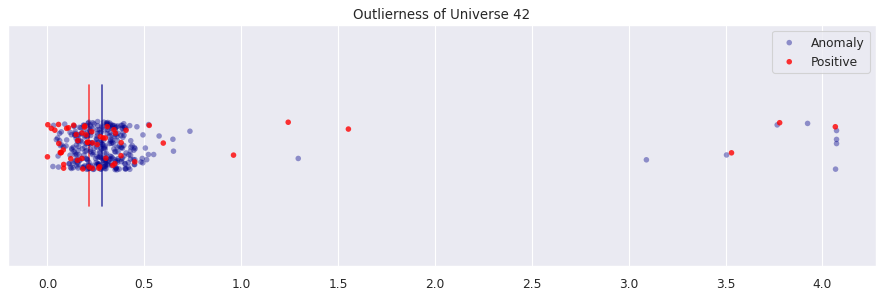

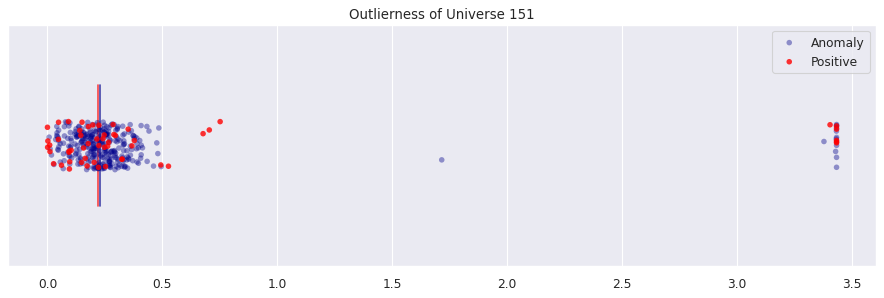

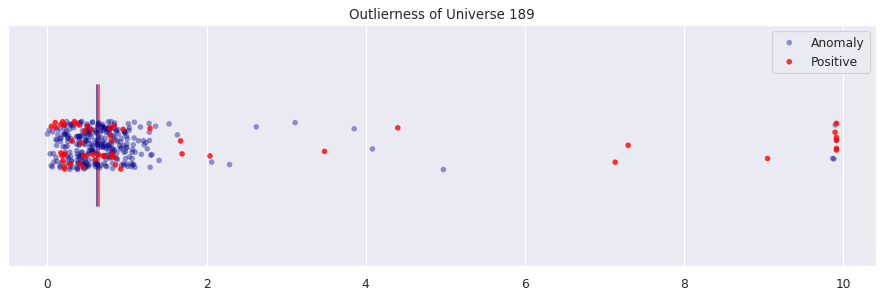

In [138]:
# Supervised outlierness visualization
vis = ToolsVisualization()

vis.outlierness_supervised(Y_collection, outlierness_pred)

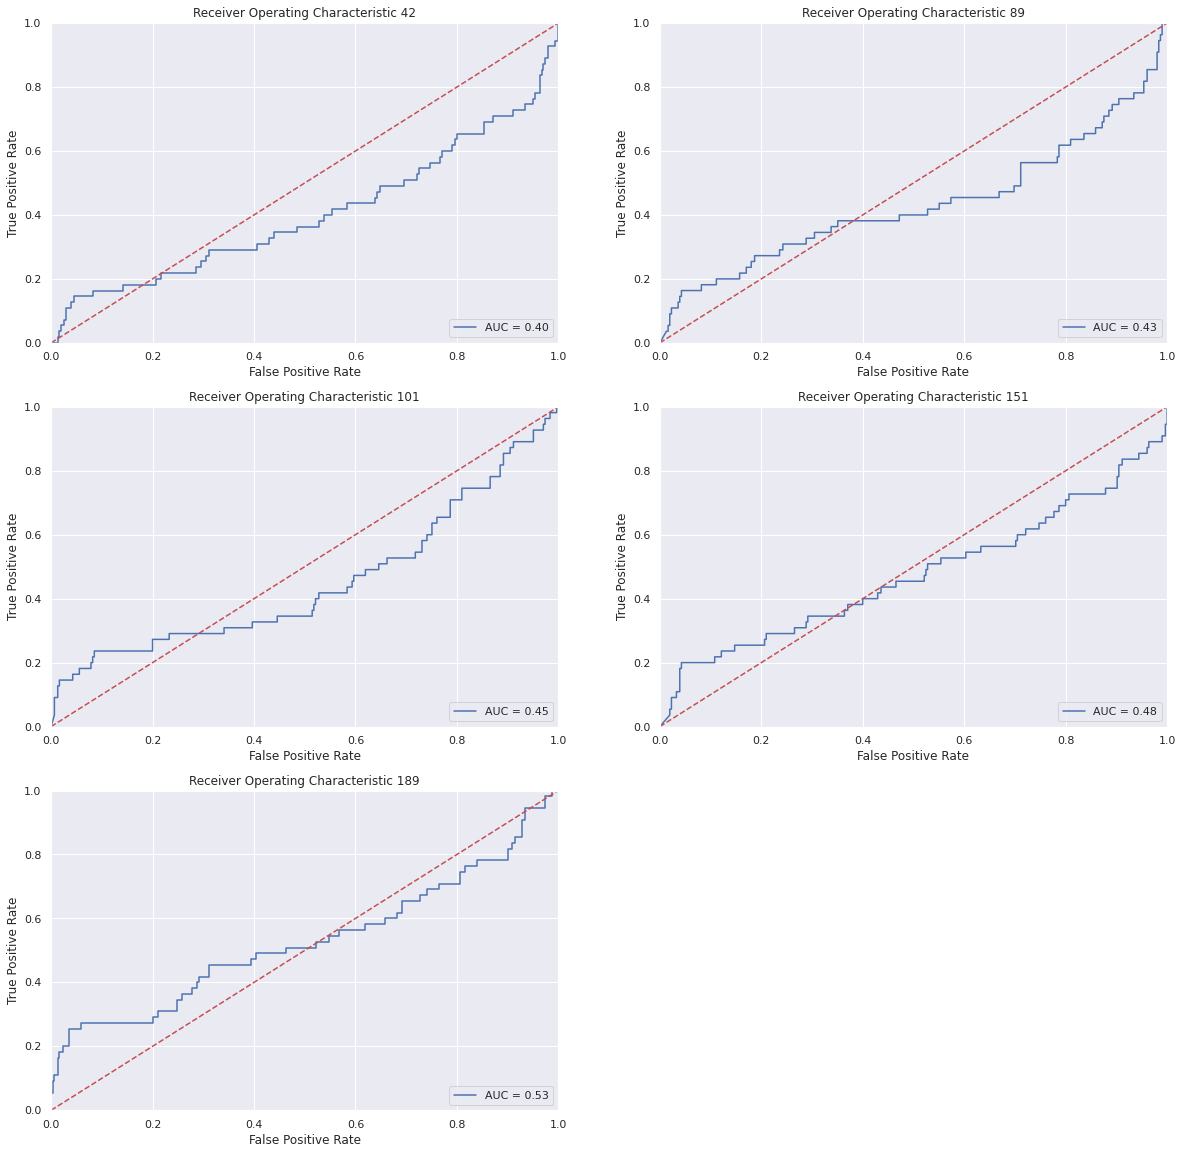

In [139]:
vis = ToolsVisualization()

vis.ROC_plot_total(Y_collection, outlierness_pred, 1)

**CONFUSION MATRIX**

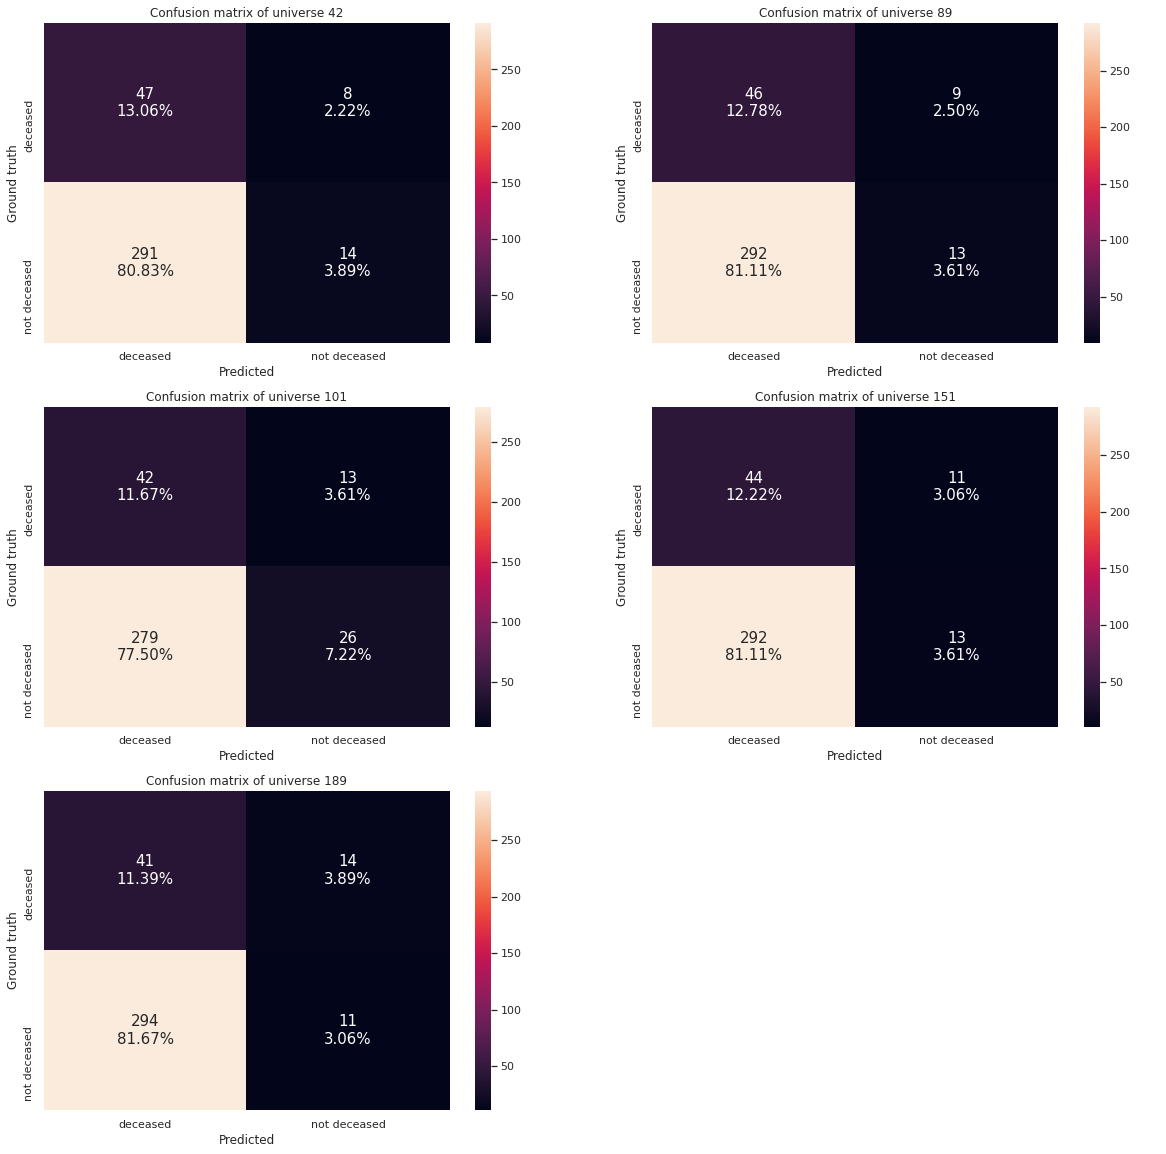

In [140]:
vis.confusion_matrix_plot_total(Y_collection, y_pred, [1, -1], normal='deceased',anomaly='not deceased')

**EVALUATION METRICS**

In [141]:
ev = tool.metric_evaluation(Y_collection, y_pred, outlierness_pred, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       47 8      |       46 9      |       42 13     |       44 11     |       41 14     |
| Negative        |      291 14     |      292 13     |      279 26     |      292 13     |      294 11     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.403      |      0.434      |      0.453      |      0.475      |      0.530*     |
| Accuracy        |      0.169      |      0.164      |      0.189*     |      0.158      |      0.144      |
| Precision       |      0.139*     |      0.136      |      0.131      |      0.131      |      0.122      |
| Sensitiv

### Default parameters

**Pipeline configuration:**

* <u>Feature filtering</u>
    * Features to keep (a priori knowledge): 
    * Filer method:
    * Outcome performance metric:
    * Columns to drop:

* <u>Row removal</u>
    * Discard quantile:

* <u>Hyperparameter optimization</u>
    * Parameters:
* <u>Prediction</u>
    * Cut-off value selection method:

In [142]:
pl = Pipeline(OneClassSVM(), X_collection, Y_collection, feature_keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE'], f_filter ='var_ratio', f_perf = 'med_mean', parameters = {})

############# FILTERING #############

# ['med', 'med_mean', 'auc']
pl.feature_filtering(n_drop = 25)

############# ROW REMOVAL #############

outss = pl.row_removal(visual = 0)

############# MODEL FITTING #############

pl.fit()

############# MODEL PREDICTION (outlierness) #############

outlierness_pred = pl.outlierness()

############# MODEL PREDICTION #############

y_pred = pl.predict('auto')



 # Applying feature filtering:
	 Filtering mode: var_ratio
	 Outcome quality measure metric: med_mean


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Best configuration (median difference):
 	 * Difference: 0.02439398597630184 
 	 * Filtering: var_ratio 
 	 * Removed features: 21
Best configuration (median difference) (mean universe):
 	 * Difference: 0.0048787971952603685 
 	 * Filtering: var_ratio 
 	 * Removed features: 21
Best configuration (AUC):
 	 * AUC: 0.5917473919523101  
 	 * Filtering: var_ratio 
 	 * Removed features: 1
Filtering applied. 21 columns removed based on var_ratio. Performace measured with med_mean.

 # Applying row removal:
	 Quantile (removal): 0.9


Universe 42:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 89:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 101:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 151:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 189:   0%|          | 0/5 [00:00<?, ?it/s]


 # Fitting data...


Classifier fitting:   0%|          | 0/5 [00:00<?, ?it/s]


 # Processing outlierness...

 # Predicting labels:
	 Cutoff value selection method: auto

 # Processing outlierness...


**Outlierness visualization (supervised)**

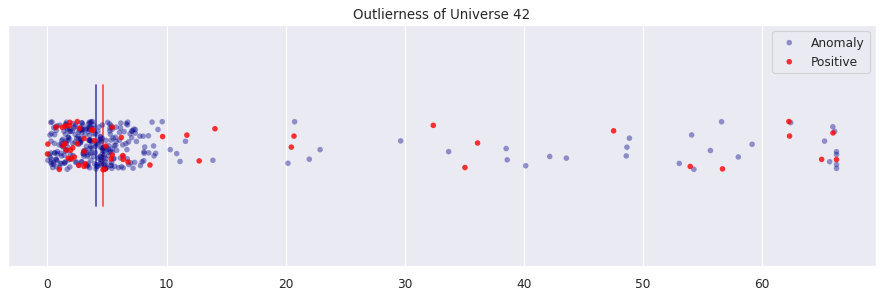

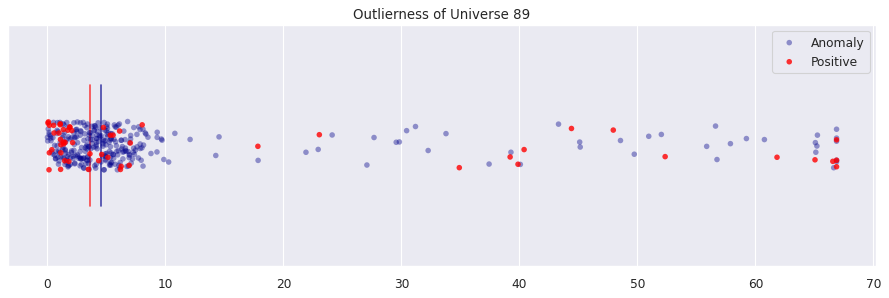

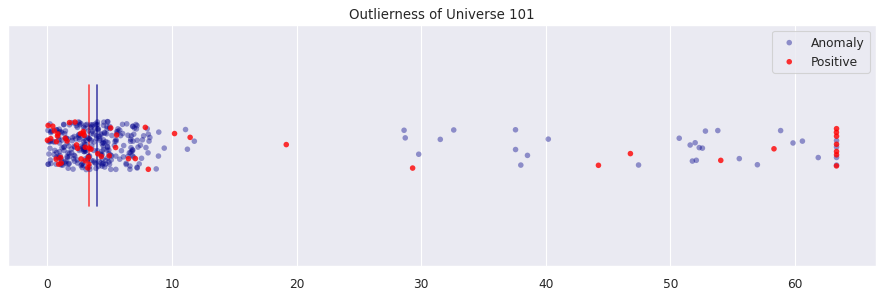

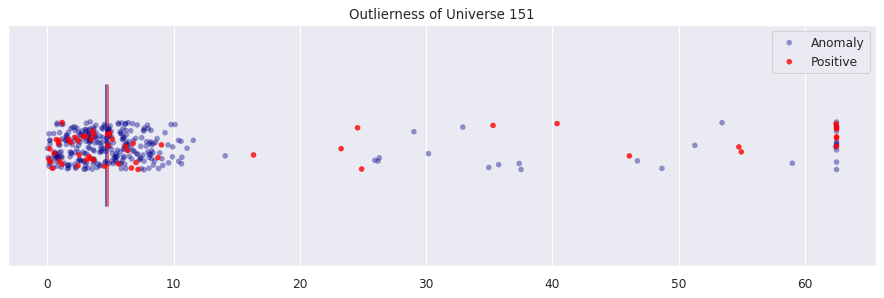

In [143]:
vis = ToolsVisualization()

vis.outlierness_supervised(Y_collection, outlierness_pred)

**ROC AUC**

In [144]:
vis = ToolsVisualization()

vis.ROC_plot_total(Y_collection, outlierness_pred, 1)

**CONFUSION MATRIX**

In [145]:
vis.confusion_matrix_plot_total(Y_collection, y_pred, [1, -1], normal='deceased',anomaly='not deceased')

**EVALUATION METRICS**

In [146]:
ev = tool.metric_evaluation(Y_collection, y_pred, outlierness_pred, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       20 35     |       27 28     |       25 30     |       23 32     |       20 35     |
| Negative        |     106 199     |     119 186     |     120 185     |     113 192     |     132 173     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.546      |      0.457      |      0.508      |      0.518      |      0.586*     |
| Accuracy        |      0.608*     |      0.592      |      0.583      |      0.597      |      0.536      |
| Precision       |      0.159      |      0.185*     |      0.172      |      0.169      |      0.132      |
| Sensitiv

**Precision-Recall Curve**

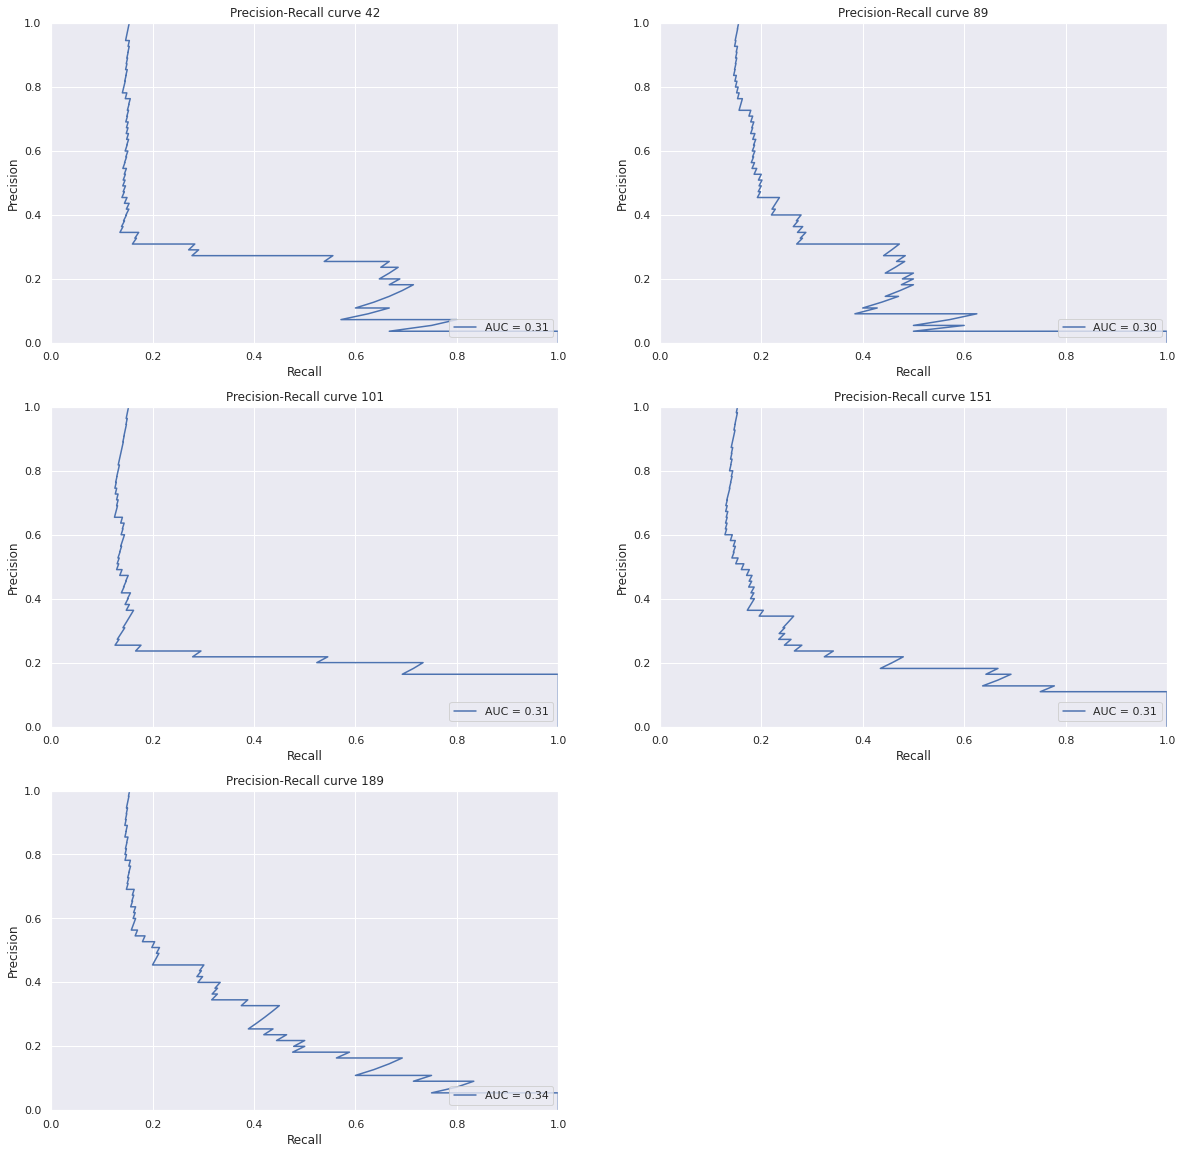

In [440]:
vis = ToolsVisualization()

vis.precision_recall_plot_total(Y_collection, outlierness_pred, 1)

## Autoencoder

**Pipeline configuration:**

* <u>Feature filtering</u>
    * Features to keep (a priori knowledge): 
    * Filer method:
    * Outcome performance metric:
    * Columns to drop:

* <u>Row removal</u>
    * Discard quantile:

* <u>Hyperparameter optimization</u>
    * Parameters:
* <u>Prediction</u>
    * Cut-off value selection method:

In [247]:
estimator_ae = auto_encoder.AutoEncoder(hidden_neurons=[32, 16, 16, 32], contamination=0.5, epochs=100, verbose = 0)

pl = Pipeline(estimator_ae, X_collection, Y_collection, feature_keep = ['CD0000AGE', 'CTHSDXXSAT', 'CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE'], f_filter ='var_ratio', f_perf = 'med_mean', parameters = {})

############# FILTERING #############

# ['med', 'med_mean', 'auc']
pl.feature_filtering(n_drop = 10)

############# ROW REMOVAL #############

outlierness_row = pl.row_removal(visual = 0)

############# MODEL FITTING #############

pl.fit()

############# MODEL PREDICTION (outlierness) #############

outlierness_pred = pl.outlierness()

############# MODEL PREDICTION #############

y_pred = pl.predict()



 # Applying feature filtering:
	 Filtering mode: var_ratio
	 Outcome quality measure metric: med_mean


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Best configuration (median difference):
 	 * Difference: 0.03841812058427255 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (median difference) (mean universe):
 	 * Difference: 0.00768362411685451 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (AUC):
 	 * AUC: 0.6542295381801555  
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Filtering applied. 9 columns removed based on var_ratio. Performace measured with med_mean.

 # Applying row removal:
	 Quantile (removal): 0.9


Universe 42:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 89:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 101:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 151:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 189:   0%|          | 0/5 [00:00<?, ?it/s]


 # Fitting data...


Classifier fitting:   0%|          | 0/5 [00:00<?, ?it/s]


 # Processing outlierness...

 # Predicting labels:
	 Cutoff value selection method: ROC

 # Processing outlierness...


**Outlierness visualization (supervised)**

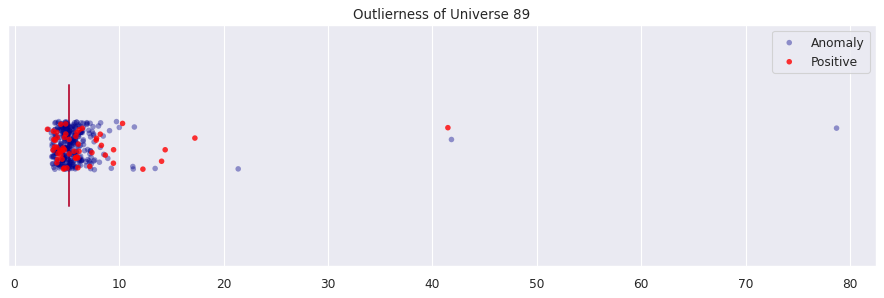

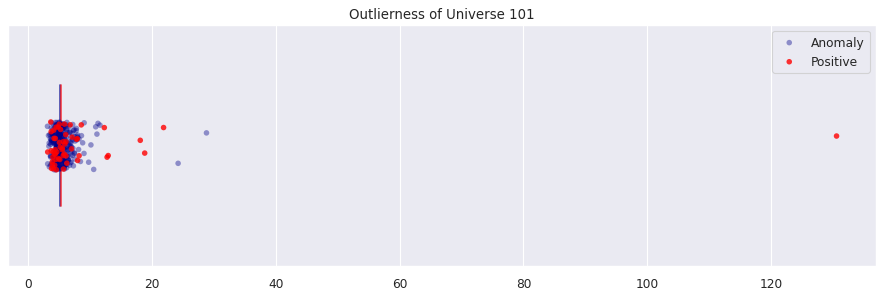

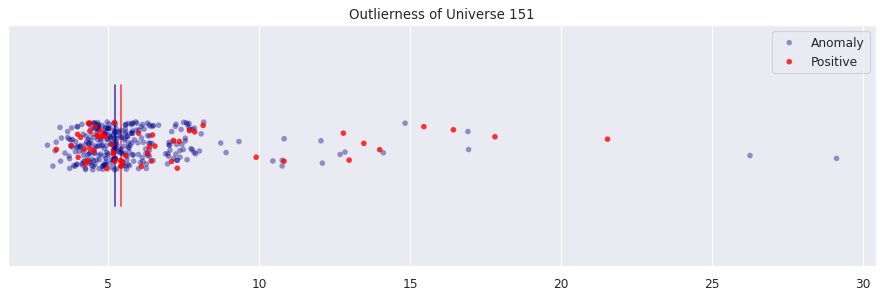

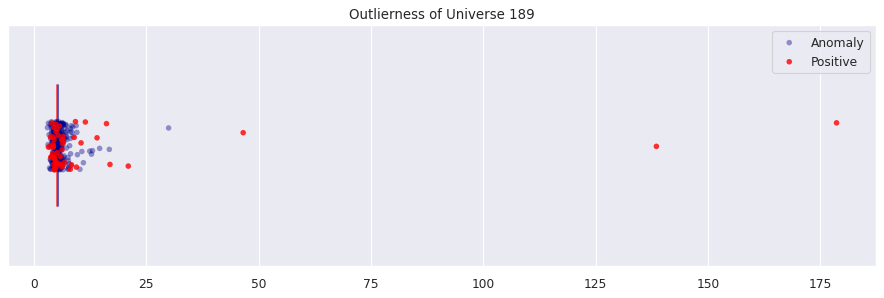

In [248]:
vis = ToolsVisualization()

vis.outlierness_supervised(Y_collection, outlierness_pred)

**ROC**

In [249]:
vis = ToolsVisualization()

vis.ROC_plot_total(Y_collection, outlierness_pred, 1)

**Precision-Recall Curve**

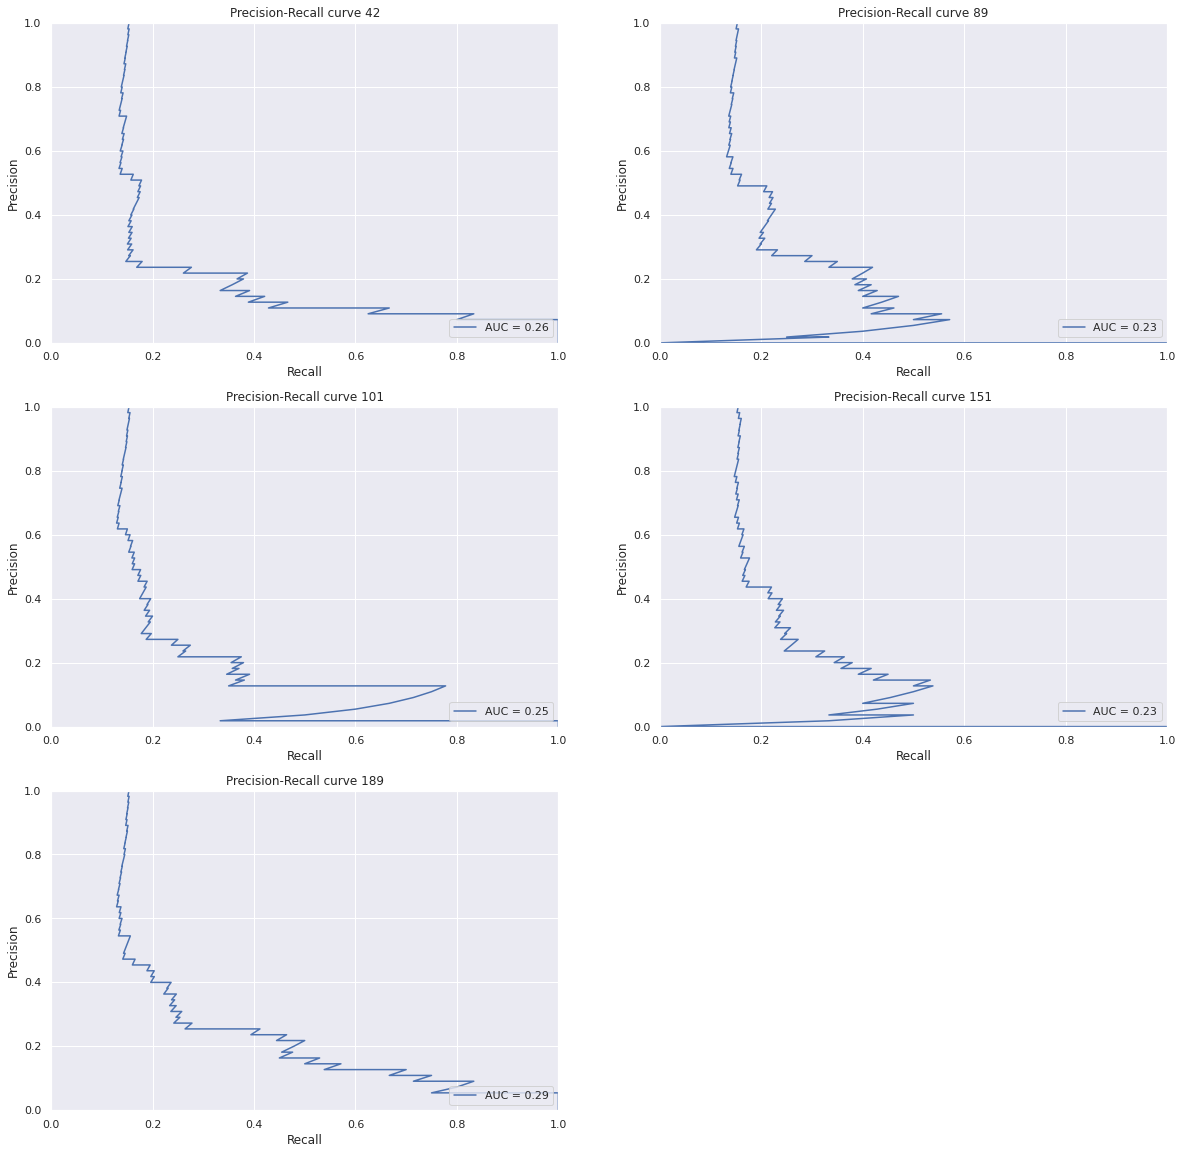

In [250]:
vis = ToolsVisualization()

vis.precision_recall_plot_total(Y_collection, outlierness_pred, 1)

**CONFUSION MATRIX**

In [251]:
vis.confusion_matrix_plot_total(Y_collection, y_pred, [1, -1], normal='deceased',anomaly='not deceased')

**EVALUATION METRICS**

In [493]:
ev = tool.metric_evaluation(Y_collection, y_pred, outlierness_pred, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       44 11     |       40 15     |       41 14     |       36 19     |       36 19     |
| Negative        |      288 17     |      268 37     |      273 32     |      246 59     |      251 54     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.486      |      0.505      |      0.500      |      0.545*     |      0.494      |
| Accuracy        |      0.169      |      0.214      |      0.203      |      0.264*     |      0.250      |
| Precision       |      0.133*     |      0.130      |      0.131      |      0.128      |      0.125      |
| Sensitiv

## LOF

### Fixed parameters

#### neighbors = 5

**Pipeline configuration:**

* <u>Feature filtering</u>
    * Features to keep (a priori knowledge): 
    * Filer method:
    * Outcome performance metric:
    * Columns to drop:

* <u>Row removal</u>
    * Discard quantile:

* <u>Hyperparameter optimization</u>
    * Parameters:
* <u>Prediction</u>
    * Cut-off value selection method:

In [163]:
lof_parameters= {
    'n_neighbors': 5
}

pl = Pipeline(lof.LOF(n_neighbors = 5), X_collection, Y_collection, feature_keep = ['CD0000AGE', 'CTHSDXXSAT', 'CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE'], f_filter ='var_ratio')

############# FILTERING #############

pl._fil = 'var_ratio'
# ['med', 'med_mean', 'auc']
pl.feature_filtering(n_drop = 25)

############# ROW REMOVAL #############

outss = pl.row_removal(visual = 0)

############# HYPERPARAMETER OPTIMIZATION #############


# Results made by filtering with variance RATIO (15 drop)

# pl.hyperparameter_optimization()

############# MODEL FITTING #############

pl.fit()

############# MODEL PREDICTION (outlierness) #############

outlierness_pred = pl.outlierness()

############# MODEL PREDICTION #############

y_pred = pl.predict('ROC')



 # Applying feature filtering:
	 Filtering mode: var_ratio
	 Outcome quality measure metric: med_mean


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Best configuration (median difference):
 	 * Difference: 0.022702535636574483 
 	 * Filtering: var_ratio 
 	 * Removed features: 23
Best configuration (median difference) (mean universe):
 	 * Difference: 0.0045405071273148965 
 	 * Filtering: var_ratio 
 	 * Removed features: 23
Best configuration (AUC):
 	 * AUC: 0.6577868852459016  
 	 * Filtering: var_ratio 
 	 * Removed features: 24
Filtering applied. 23 columns removed based on var_ratio. Performace measured with med_mean.

 # Applying row removal:
	 Quantile (removal): 0.9


Universe 42:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 89:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 101:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 151:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 189:   0%|          | 0/5 [00:00<?, ?it/s]


 # Fitting data...


Classifier fitting:   0%|          | 0/5 [00:00<?, ?it/s]


 # Processing outlierness...

 # Predicting labels:
	 Cutoff value selection method: ROC

 # Processing outlierness...


**Outlierness visualization (supervised)**

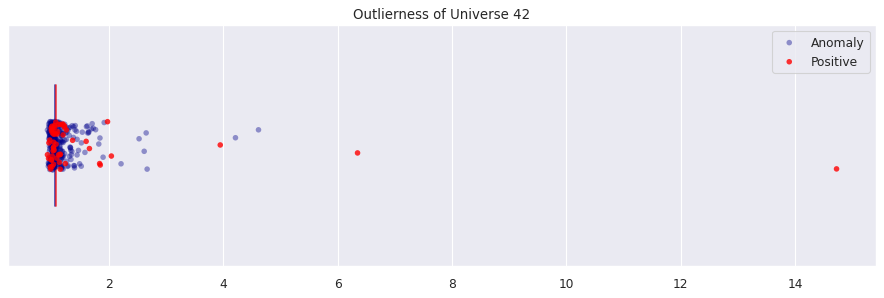

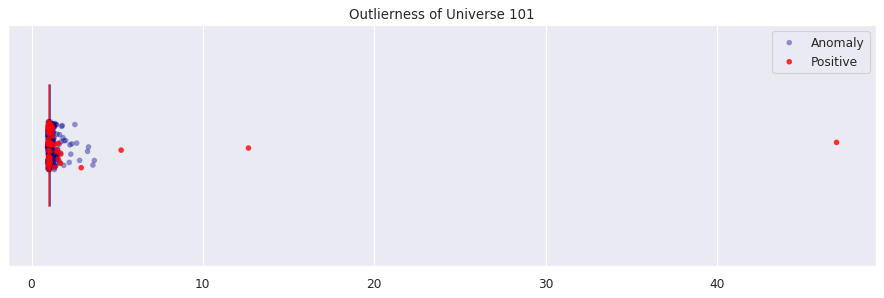

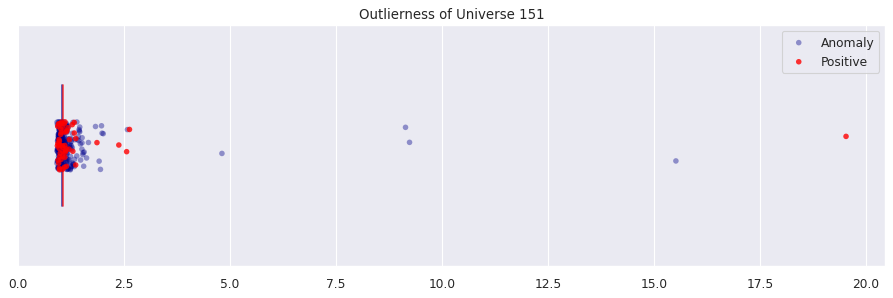

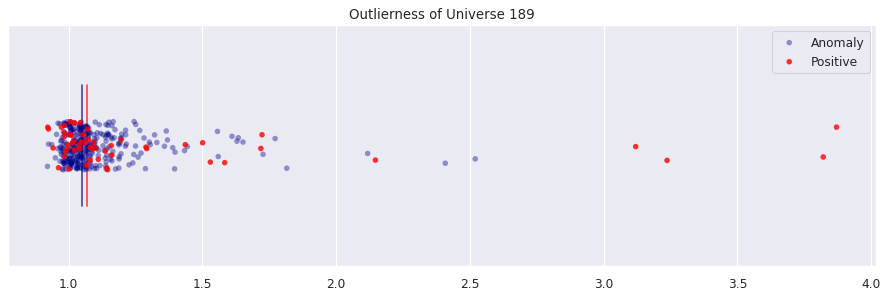

In [164]:
vis = ToolsVisualization()

vis.outlierness_supervised(Y_collection, outlierness_pred)

**ROC**

In [165]:
vis = ToolsVisualization()

vis.ROC_plot_total(Y_collection, outlierness_pred, 1)

**CONFUSION MATRIX**

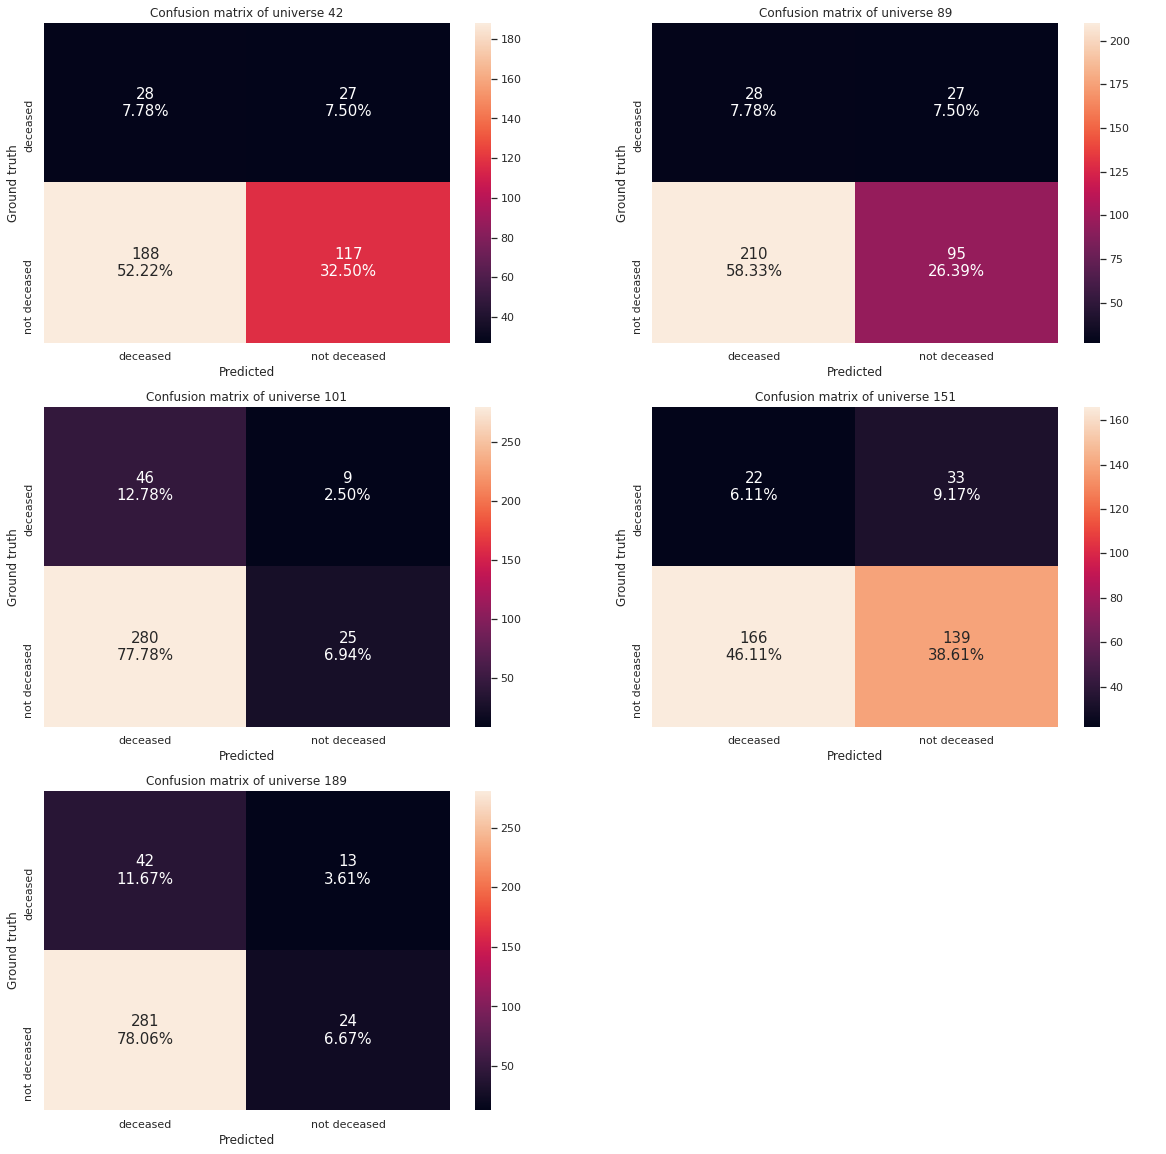

In [166]:
vis.confusion_matrix_plot_total(Y_collection, y_pred, [1, -1], normal='deceased',anomaly='not deceased')

**EVALUATION METRICS**

In [167]:
ev = tool.metric_evaluation(Y_collection, y_pred, outlierness_pred, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       28 27     |       28 27     |       46 9      |       22 33     |       42 13     |
| Negative        |     188 117     |      210 95     |      280 25     |     166 139     |      281 24     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.541      |      0.564*     |      0.487      |      0.535      |      0.537      |
| Accuracy        |      0.403      |      0.342      |      0.197      |      0.447*     |      0.183      |
| Precision       |      0.130      |      0.118      |      0.141*     |      0.117      |      0.130      |
| Sensitiv

#### neighbors = 10

**Pipeline configuration:**

* <u>Feature filtering</u>
    * Features to keep (a priori knowledge): 
    * Filer method:
    * Outcome performance metric:
    * Columns to drop:

* <u>Row removal</u>
    * Discard quantile:

* <u>Hyperparameter optimization</u>
    * Parameters:
* <u>Prediction</u>
    * Cut-off value selection method:

In [221]:
pl = Pipeline(lof.LOF(n_neighbors = 10), X_collection, Y_collection, feature_keep = ['CD0000AGE', 'CTHSDXXSAT', 'CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE'], f_filter ='var_ratio')

############# FILTERING #############

pl._fil = 'var_ratio'
# ['med', 'med_mean', 'auc']
pl.feature_filtering(n_drop = 25)

############# ROW REMOVAL #############

outss = pl.row_removal(visual = 0)

############# HYPERPARAMETER OPTIMIZATION #############


# Results made by filtering with variance RATIO (15 drop)

# pl.hyperparameter_optimization()

############# MODEL FITTING #############

pl.fit()

############# MODEL PREDICTION (outlierness) #############

outlierness_pred = pl.outlierness()

############# MODEL PREDICTION #############

y_pred = pl.predict('ROC')



 # Applying feature filtering:
	 Filtering mode: var_ratio
	 Outcome quality measure metric: med_mean


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Best configuration (median difference):
 	 * Difference: 0.0058637217885501025 
 	 * Filtering: var_ratio 
 	 * Removed features: 24
Best configuration (median difference) (mean universe):
 	 * Difference: 0.0011727443577100205 
 	 * Filtering: var_ratio 
 	 * Removed features: 24
Best configuration (AUC):
 	 * AUC: 0.6836810730253353  
 	 * Filtering: var_ratio 
 	 * Removed features: 19
Filtering applied. 24 columns removed based on var_ratio. Performace measured with med_mean.

 # Applying row removal:
	 Quantile (removal): 0.9


Universe 42:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 89:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 101:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 151:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 189:   0%|          | 0/5 [00:00<?, ?it/s]


 # Fitting data...


Classifier fitting:   0%|          | 0/5 [00:00<?, ?it/s]


 # Processing outlierness...

 # Predicting labels:
	 Cutoff value selection method: ROC

 # Processing outlierness...


**Outlierness visualization (supervised)**

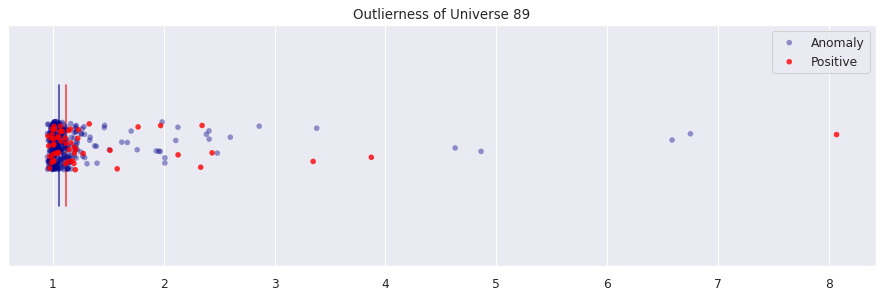

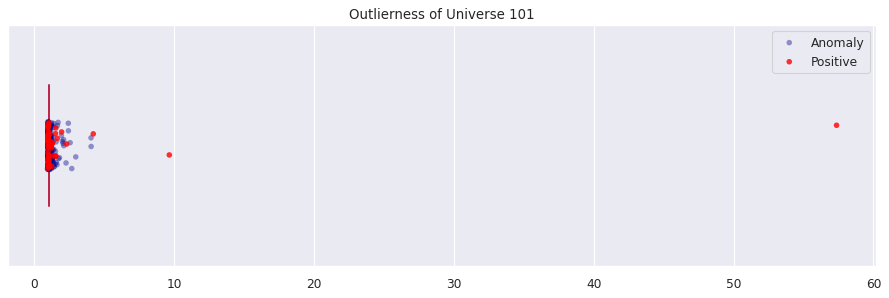

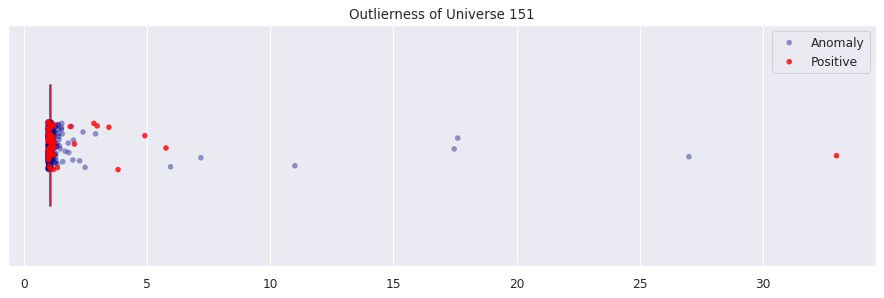

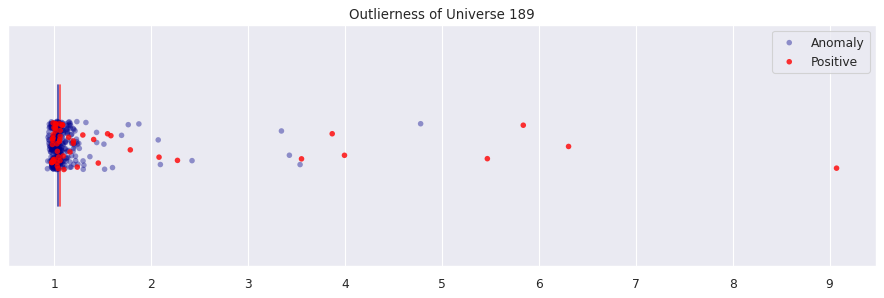

In [222]:
vis = ToolsVisualization()

vis.outlierness_supervised(Y_collection, outlierness_pred)

**ROC**

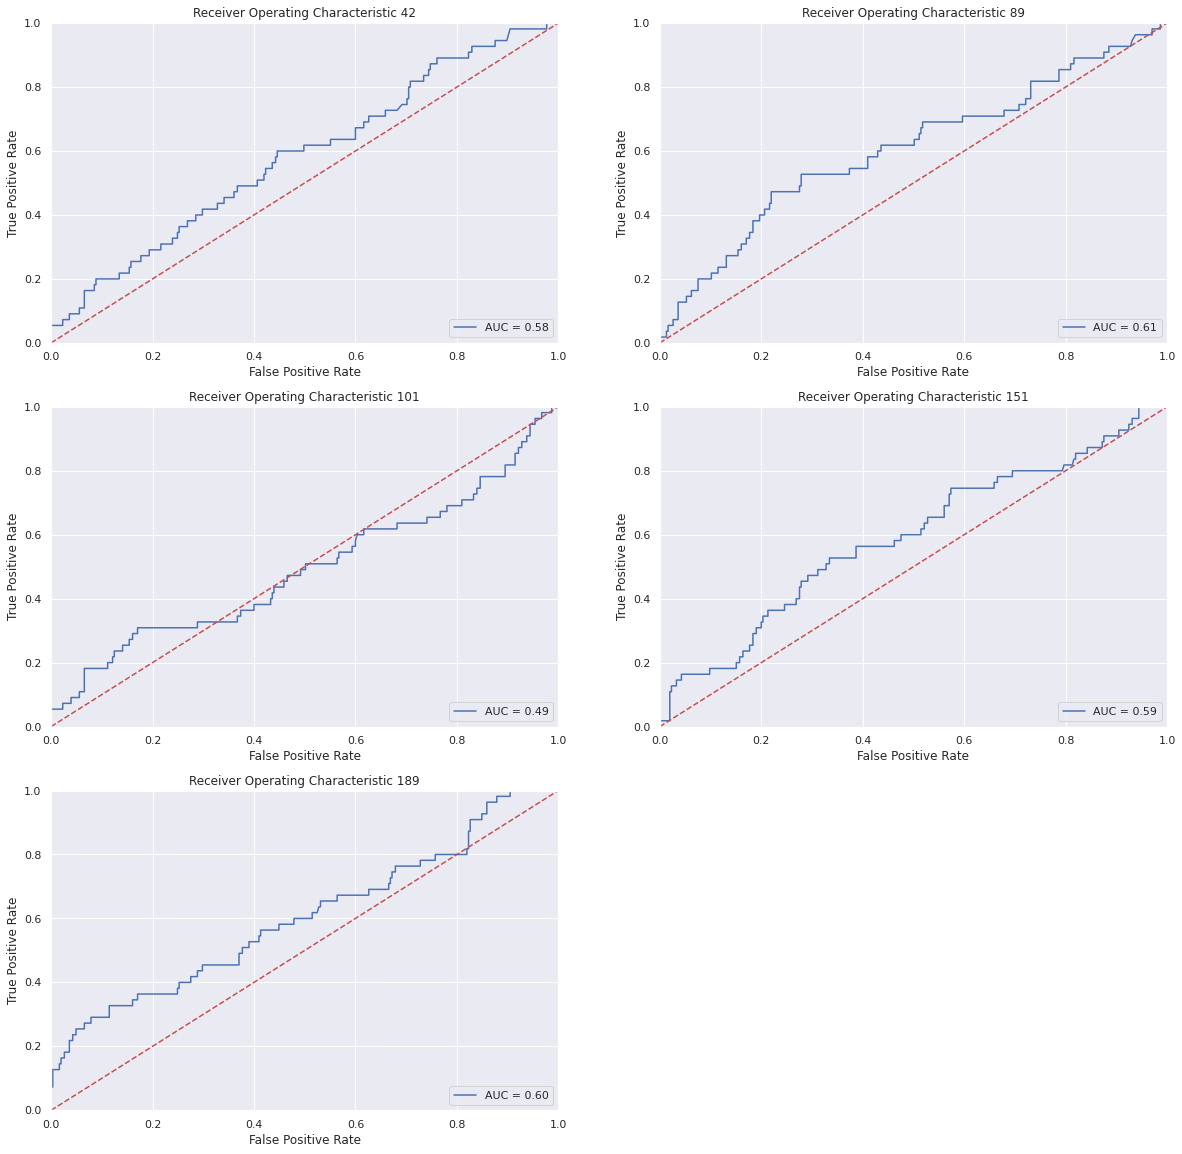

In [223]:
vis = ToolsVisualization()

vis.ROC_plot_total(Y_collection, outlierness_pred, 1)

**CONFUSION MATRIX**

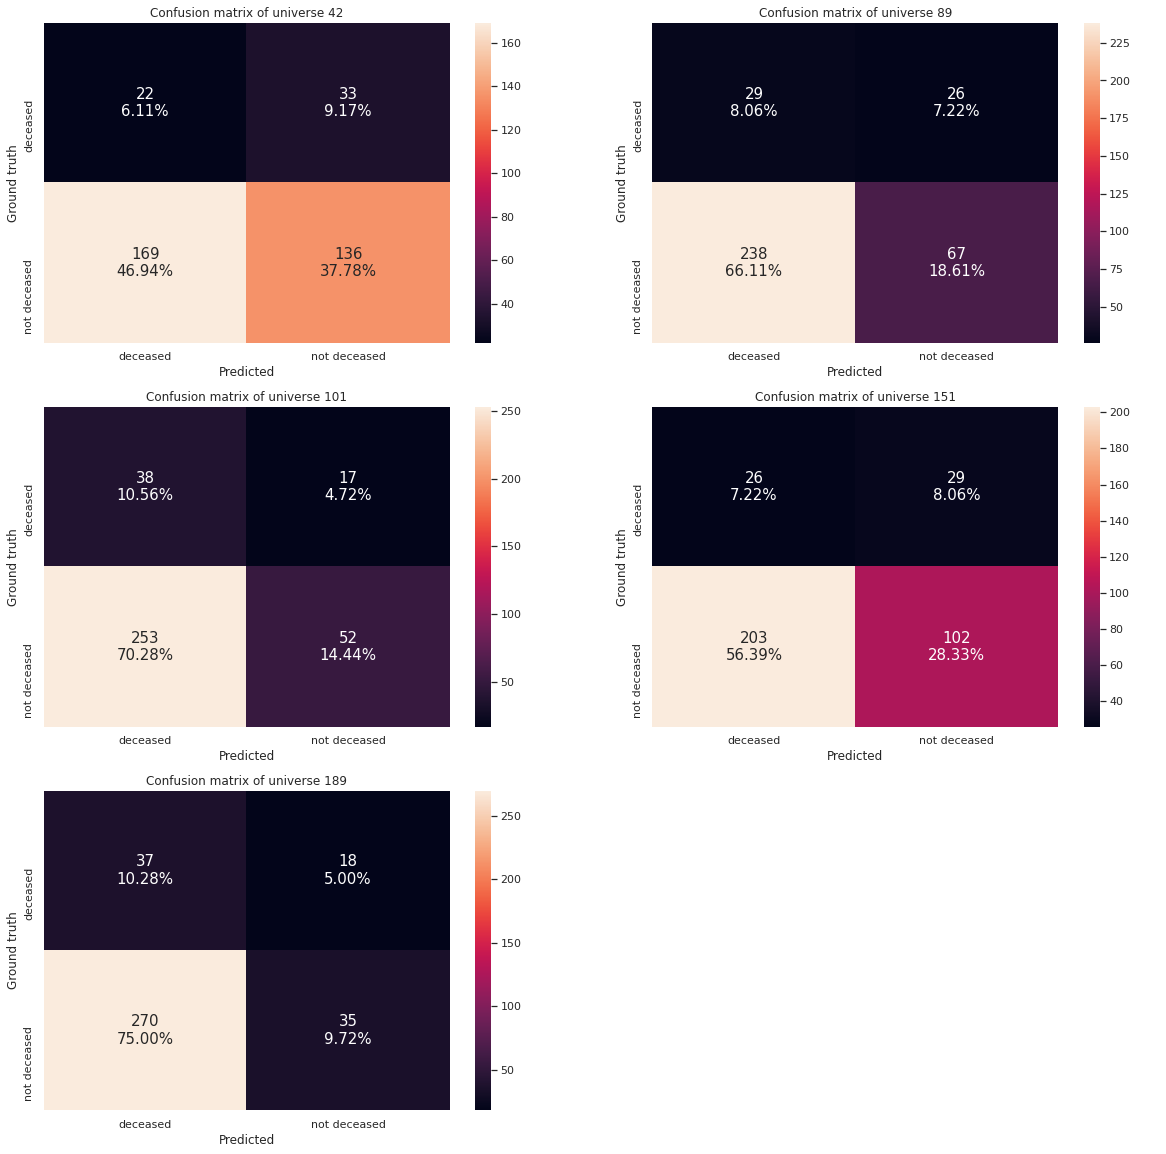

In [224]:
vis.confusion_matrix_plot_total(Y_collection, y_pred, [1, -1], normal='deceased',anomaly='not deceased')

**EVALUATION METRICS**

In [225]:
ev = tool.metric_evaluation(Y_collection, y_pred, outlierness_pred, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       22 33     |       29 26     |       38 17     |       26 29     |       37 18     |
| Negative        |     169 136     |      238 67     |      253 52     |     203 102     |      270 35     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.581      |      0.607*     |      0.493      |      0.590      |      0.604      |
| Accuracy        |      0.439*     |      0.267      |      0.250      |      0.356      |      0.200      |
| Precision       |      0.115      |      0.109      |      0.131*     |      0.114      |      0.121      |
| Sensitiv

#### neighbors = 15

**Pipeline configuration:**

* <u>Feature filtering</u>
    * Features to keep (a priori knowledge): 
    * Filer method:
    * Outcome performance metric:
    * Columns to drop:

* <u>Row removal</u>
    * Discard quantile:

* <u>Hyperparameter optimization</u>
    * Parameters:
* <u>Prediction</u>
    * Cut-off value selection method:

In [226]:
pl = Pipeline(lof.LOF(n_neighbors = 15), X_collection, Y_collection, feature_keep = ['CD0000AGE', 'CTHSDXXSAT', 'CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE'], f_filter ='var_ratio')

############# FILTERING #############

pl._fil = 'var_ratio'
# ['med', 'med_mean', 'auc']
pl.feature_filtering(n_drop = 25)

############# ROW REMOVAL #############

outss = pl.row_removal(visual = 0)

############# MODEL FITTING #############

pl.fit()

############# MODEL PREDICTION (outlierness) #############

outlierness_pred = pl.outlierness()

############# MODEL PREDICTION #############

y_pred = pl.predict('ROC')



 # Applying feature filtering:
	 Filtering mode: var_ratio
	 Outcome quality measure metric: med_mean


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Best configuration (median difference):
 	 * Difference: 0.006400038855634657 
 	 * Filtering: var_ratio 
 	 * Removed features: 14
Best configuration (median difference) (mean universe):
 	 * Difference: 0.0012800077711269315 
 	 * Filtering: var_ratio 
 	 * Removed features: 14
Best configuration (AUC):
 	 * AUC: 0.6742734724292101  
 	 * Filtering: var_ratio 
 	 * Removed features: 5
Filtering applied. 14 columns removed based on var_ratio. Performace measured with med_mean.

 # Applying row removal:
	 Quantile (removal): 0.9


Universe 42:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 89:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 101:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 151:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 189:   0%|          | 0/5 [00:00<?, ?it/s]


 # Fitting data...


Classifier fitting:   0%|          | 0/5 [00:00<?, ?it/s]


 # Processing outlierness...

 # Predicting labels:
	 Cutoff value selection method: ROC

 # Processing outlierness...


**Local outlierness within train samples**

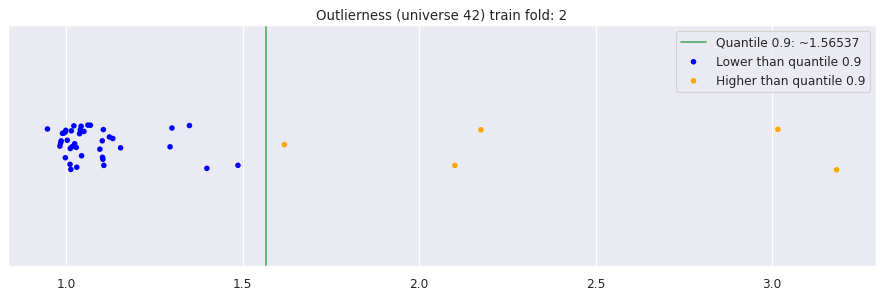

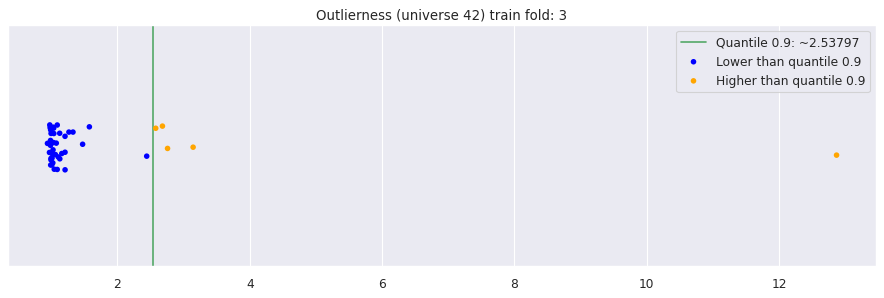

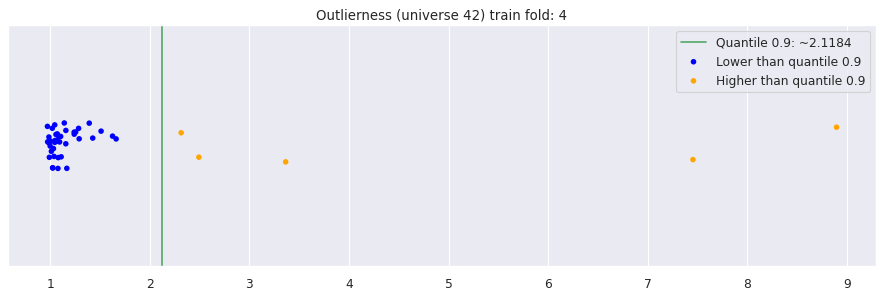

In [227]:
vis.outlierness_unsupervised(outss, quantile=0.9, title='Outlierness (universe 42) train fold: ')

**Outlierness visualization (supervised)**

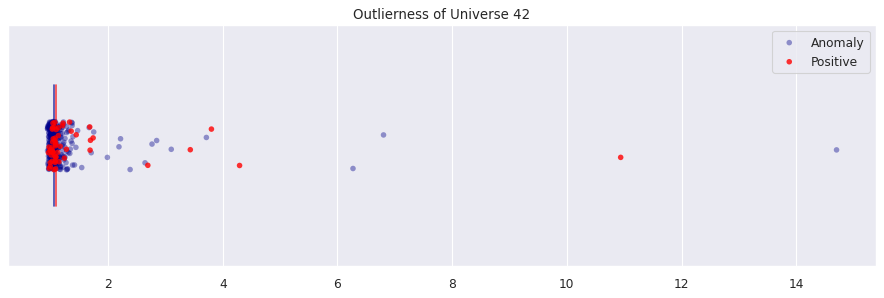

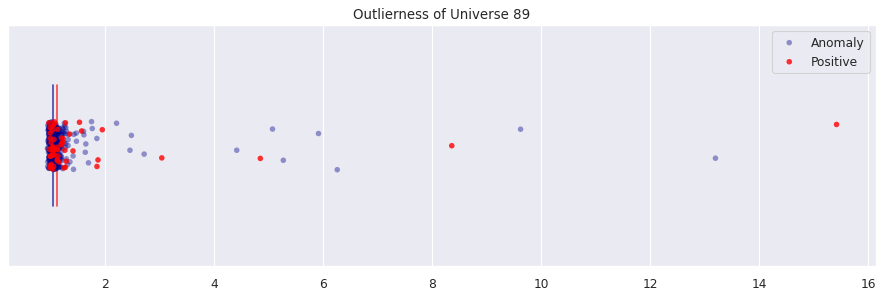

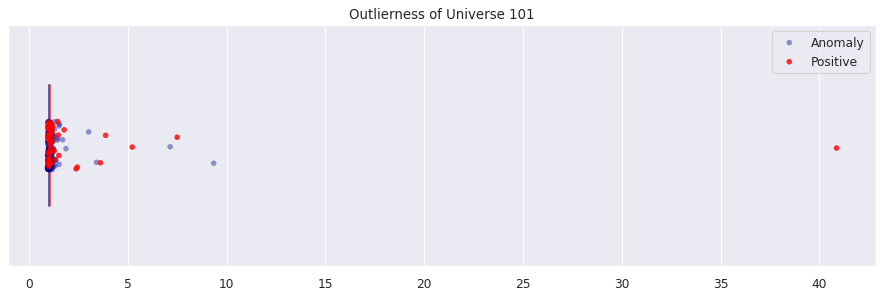

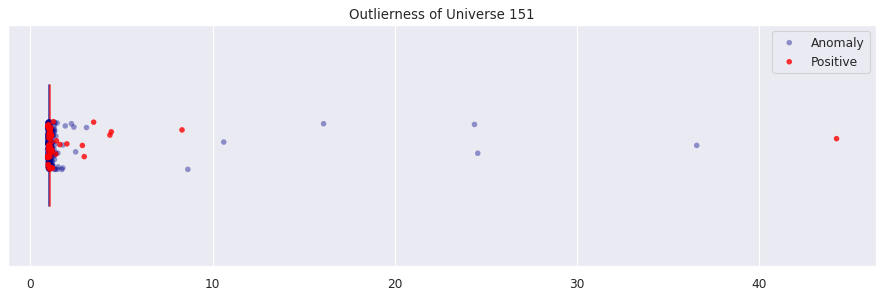

In [228]:
vis.outlierness_supervised(Y_collection, outlierness_pred)

**ROC**

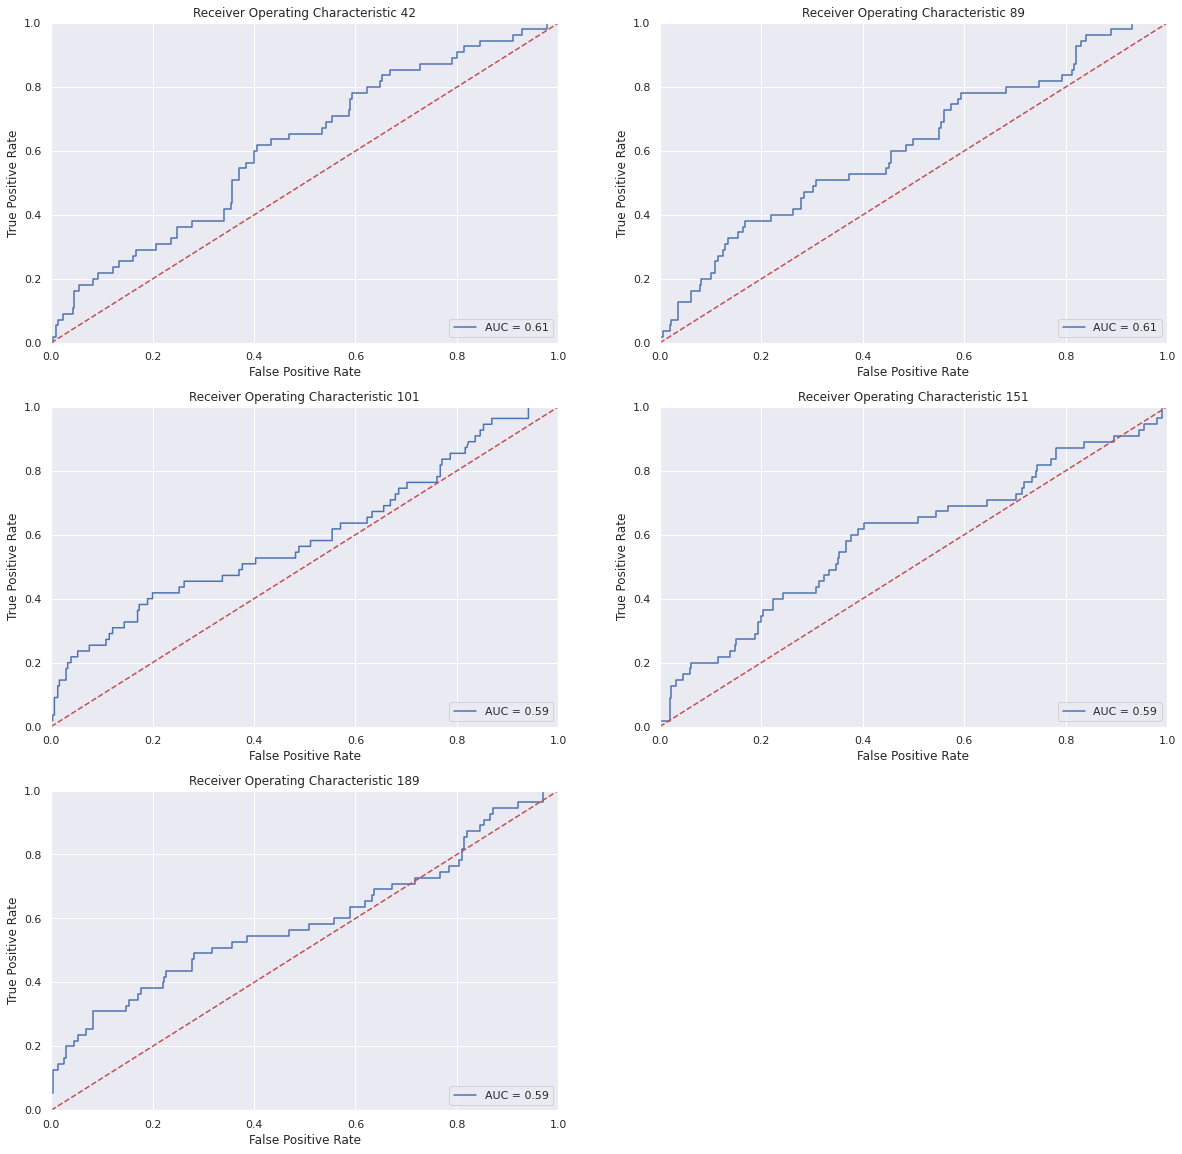

In [229]:
vis = ToolsVisualization()

vis.ROC_plot_total(Y_collection, outlierness_pred, 1)

**CONFUSION MATRIX**

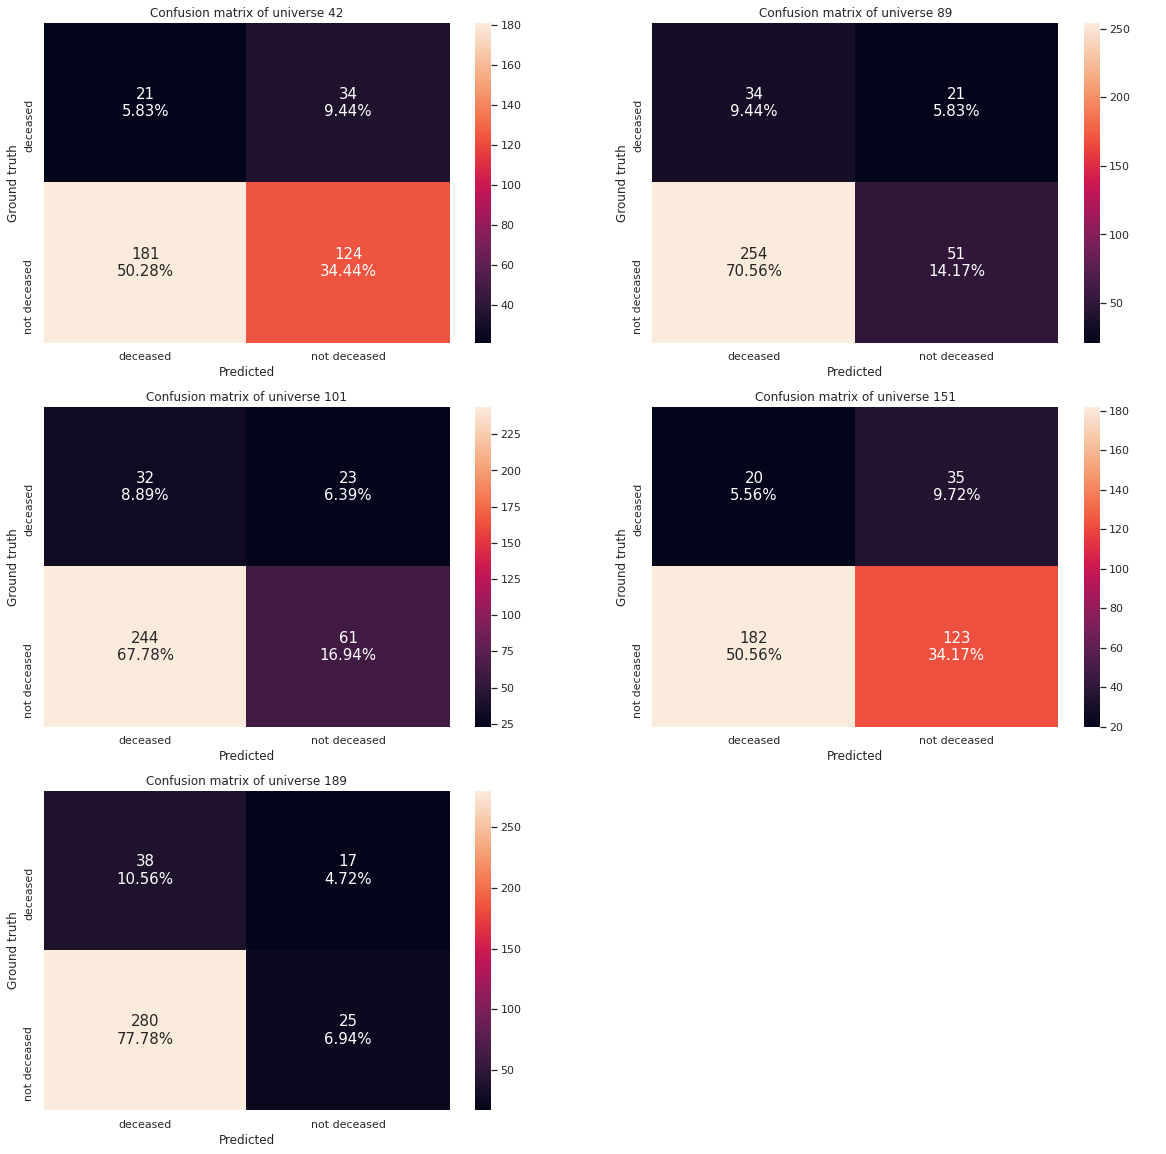

In [230]:
vis.confusion_matrix_plot_total(Y_collection, y_pred, [1, -1], normal='deceased',anomaly='not deceased')

**EVALUATION METRICS**

In [231]:
ev = tool.metric_evaluation(Y_collection, y_pred, outlierness_pred, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       21 34     |       34 21     |       32 23     |       20 35     |       38 17     |
| Negative        |     181 124     |      254 51     |      244 61     |     182 123     |      280 25     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.612      |      0.615*     |      0.594      |      0.594      |      0.592      |
| Accuracy        |      0.403*     |      0.236      |      0.258      |      0.397      |      0.175      |
| Precision       |      0.104      |      0.118      |      0.116      |      0.099      |      0.119*     |
| Sensitiv

#### neighbors = 20

**Pipeline configuration:**

* <u>Feature filtering</u>
    * Features to keep (a priori knowledge): 
    * Filer method:
    * Outcome performance metric:
    * Columns to drop:

* <u>Row removal</u>
    * Discard quantile:

* <u>Hyperparameter optimization</u>
    * Parameters:
* <u>Prediction</u>
    * Cut-off value selection method:

In [239]:
pl = Pipeline(lof.LOF(n_neighbors = 20), X_collection, Y_collection, feature_keep = ['CD0000AGE', 'CTHSDXXSAT', 'CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE'], f_filter ='var_ratio')

############# FILTERING #############

pl._fil = 'var_ratio'
# ['med', 'med_mean', 'auc']
pl.feature_filtering(n_drop = 25)

############# ROW REMOVAL #############

outss = pl.row_removal(visual = 0)

############# MODEL FITTING #############

pl.fit()

############# MODEL PREDICTION (outlierness) #############

outlierness_pred = pl.outlierness()

############# MODEL PREDICTION #############

y_pred = pl.predict('ROC')



 # Applying feature filtering:
	 Filtering mode: var_ratio
	 Outcome quality measure metric: med_mean


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Best configuration (median difference):
 	 * Difference: 0.004887737031241134 
 	 * Filtering: var_ratio 
 	 * Removed features: 15
Best configuration (median difference) (mean universe):
 	 * Difference: 0.000977547406248227 
 	 * Filtering: var_ratio 
 	 * Removed features: 15
Best configuration (AUC):
 	 * AUC: 0.6893163189269748  
 	 * Filtering: var_ratio 
 	 * Removed features: 23
Filtering applied. 15 columns removed based on var_ratio. Performace measured with med_mean.

 # Applying row removal:
	 Quantile (removal): 0.9


Universe 42:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 89:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 101:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 151:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 189:   0%|          | 0/5 [00:00<?, ?it/s]


 # Fitting data...


Classifier fitting:   0%|          | 0/5 [00:00<?, ?it/s]


 # Processing outlierness...

 # Predicting labels:
	 Cutoff value selection method: ROC

 # Processing outlierness...


**Local outlierness within train samples**

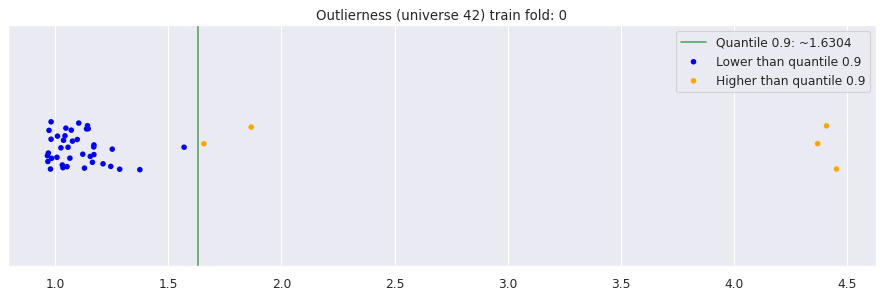

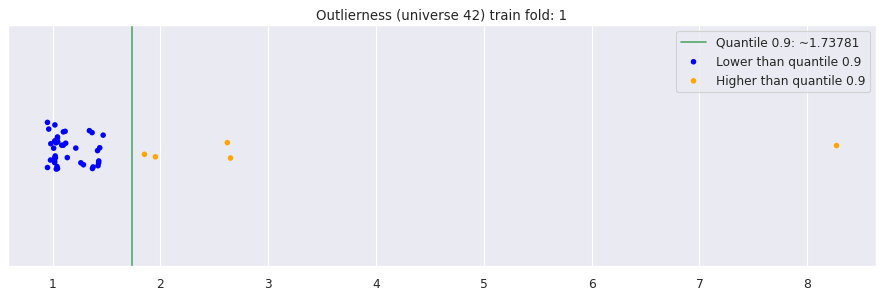

In [240]:
vis.outlierness_unsupervised(outss, quantile=0.9, title='Outlierness (universe 42) train fold: ')

**Outlierness visualization (supervised)**

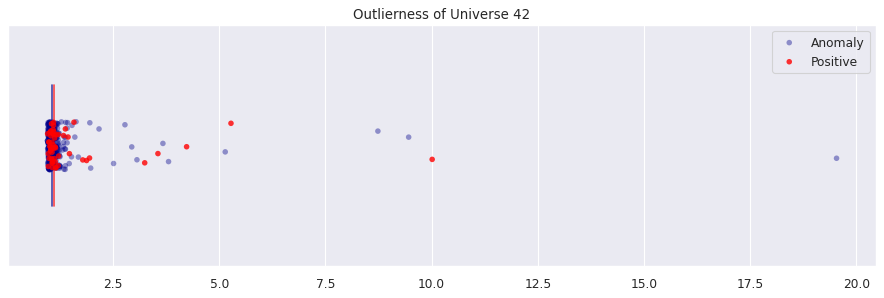

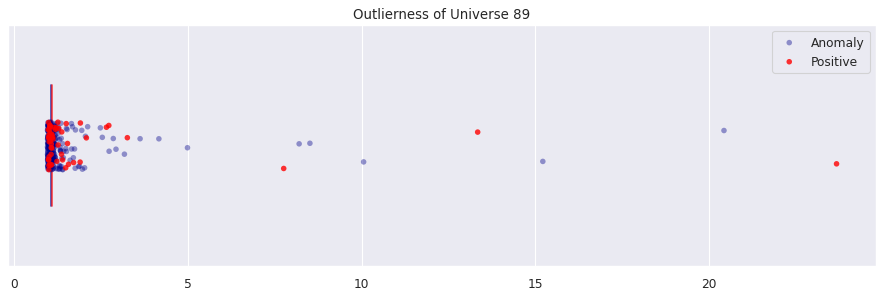

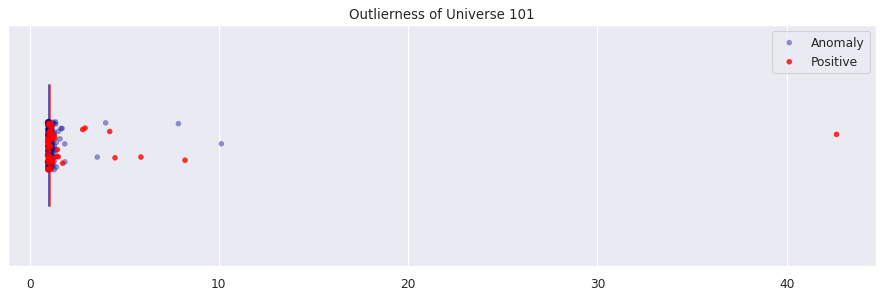

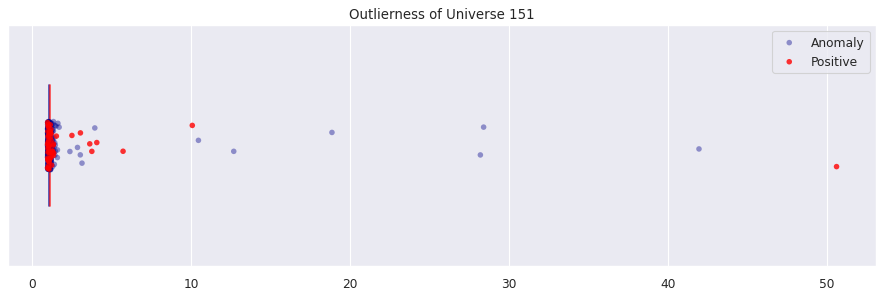

In [241]:
vis.outlierness_supervised(Y_collection, outlierness_pred)

**ROC**

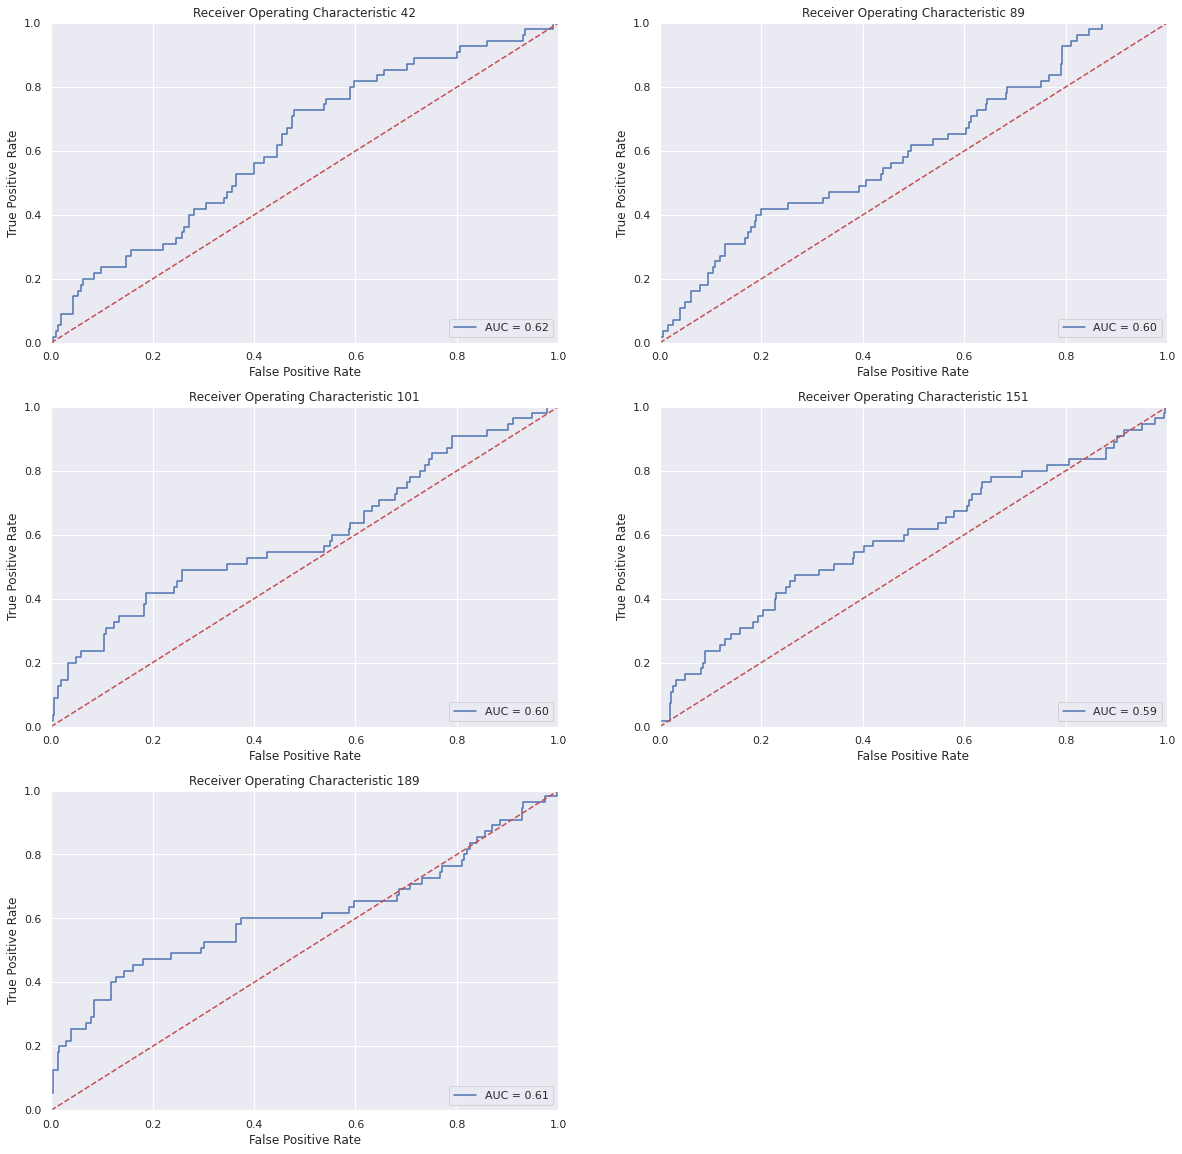

In [242]:
vis = ToolsVisualization()

vis.ROC_plot_total(Y_collection, outlierness_pred, 1)

**CONFUSION MATRIX**

In [243]:
vis.confusion_matrix_plot_total(Y_collection, y_pred, [1, -1], normal='deceased',anomaly='not deceased')

**EVALUATION METRICS**

In [244]:
ev = tool.metric_evaluation(Y_collection, y_pred, outlierness_pred, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       15 40     |       32 23     |       28 27     |       29 26     |       30 25     |
| Negative        |     159 146     |      244 61     |      226 79     |      224 81     |      256 49     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.624*     |      0.604      |      0.602      |      0.591      |      0.611      |
| Accuracy        |      0.447*     |      0.258      |      0.297      |      0.306      |      0.219      |
| Precision       |      0.086      |      0.116*     |      0.110      |      0.115      |      0.105      |
| Sensitiv

#### neighbors = 25

**Pipeline configuration:**

* <u>Feature filtering</u>
    * Features to keep (a priori knowledge): 
    * Filer method:
    * Outcome performance metric:
    * Columns to drop:

* <u>Row removal</u>
    * Discard quantile:

* <u>Hyperparameter optimization</u>
    * Parameters:
* <u>Prediction</u>
    * Cut-off value selection method:

In [252]:
pl = Pipeline(lof.LOF(n_neighbors = 25), X_collection, Y_collection, feature_keep = ['CD0000AGE', 'CTHSDXXSAT', 'CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE'], f_filter ='var_ratio')

############# FILTERING #############

pl._fil = 'var_ratio'
# ['med', 'med_mean', 'auc']
pl.feature_filtering(n_drop = 25)

############# ROW REMOVAL #############

outss = pl.row_removal(visual = 0)

############# MODEL FITTING #############

pl.fit()

############# MODEL PREDICTION (outlierness) #############

outlierness_pred = pl.outlierness()

############# MODEL PREDICTION #############

y_pred = pl.predict('ROC')



 # Applying feature filtering:
	 Filtering mode: var_ratio
	 Outcome quality measure metric: med_mean


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Best configuration (median difference):
 	 * Difference: 0.0025187348665440847 
 	 * Filtering: var_ratio 
 	 * Removed features: 7
Best configuration (median difference) (mean universe):
 	 * Difference: 0.0005037469733088169 
 	 * Filtering: var_ratio 
 	 * Removed features: 7
Best configuration (AUC):
 	 * AUC: 0.7079918032786885  
 	 * Filtering: var_ratio 
 	 * Removed features: 4
Filtering applied. 7 columns removed based on var_ratio. Performace measured with med_mean.

 # Applying row removal:
	 Quantile (removal): 0.9


Universe 42:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 89:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 101:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 151:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 189:   0%|          | 0/5 [00:00<?, ?it/s]


 # Fitting data...


Classifier fitting:   0%|          | 0/5 [00:00<?, ?it/s]


 # Processing outlierness...

 # Predicting labels:
	 Cutoff value selection method: ROC

 # Processing outlierness...


**Local outlierness within train samples**

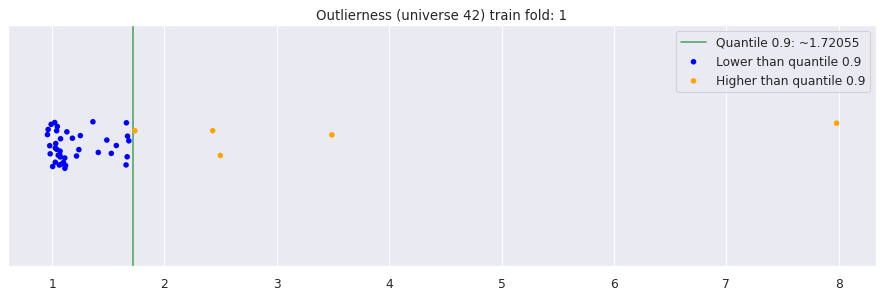

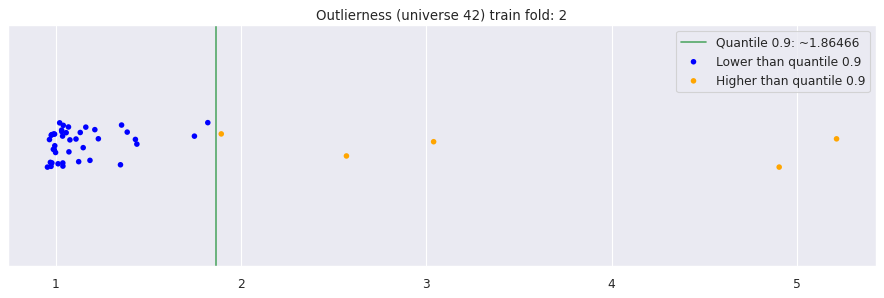

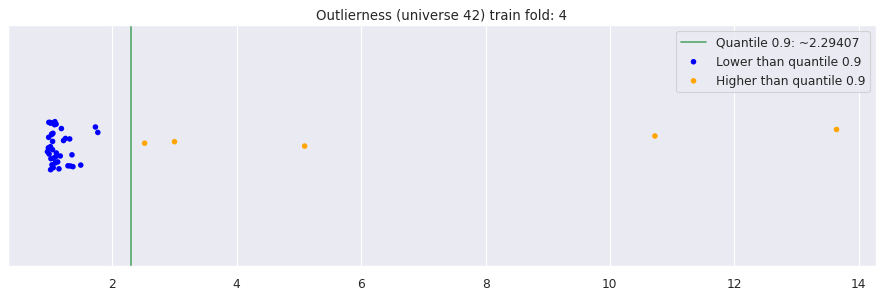

In [253]:
vis.outlierness_unsupervised(outss, quantile=0.9, title='Outlierness (universe 42) train fold: ')

**Outlierness visualization (supervised)**

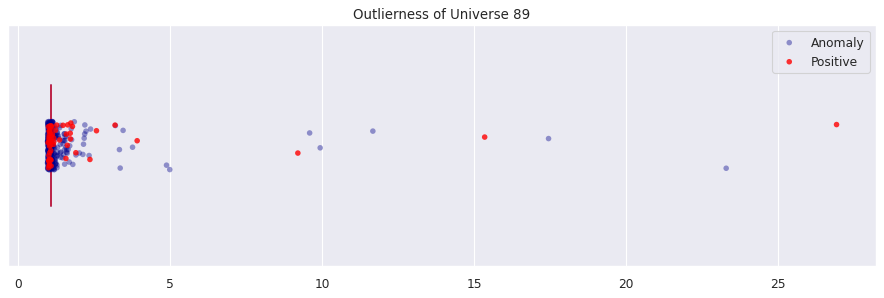

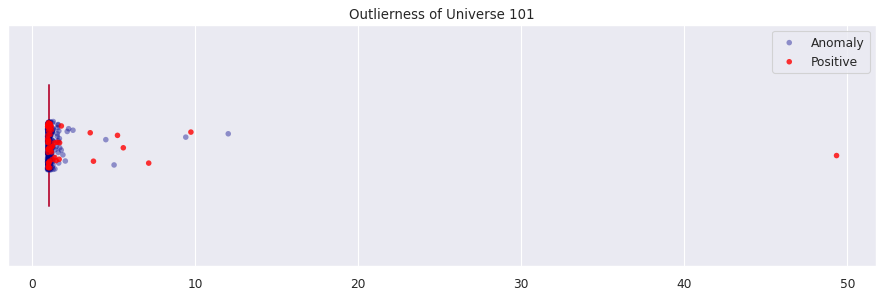

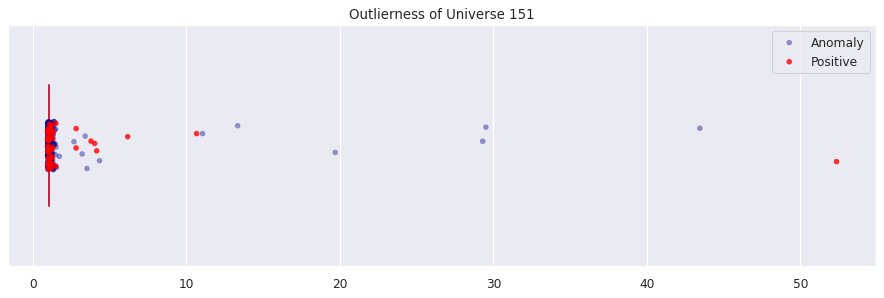

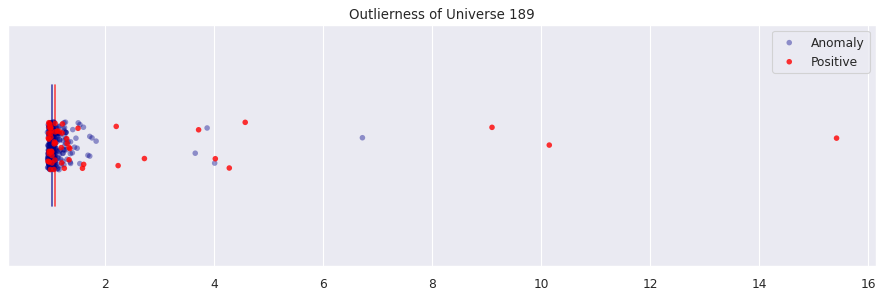

In [254]:
vis.outlierness_supervised(Y_collection, outlierness_pred)

**ROC**

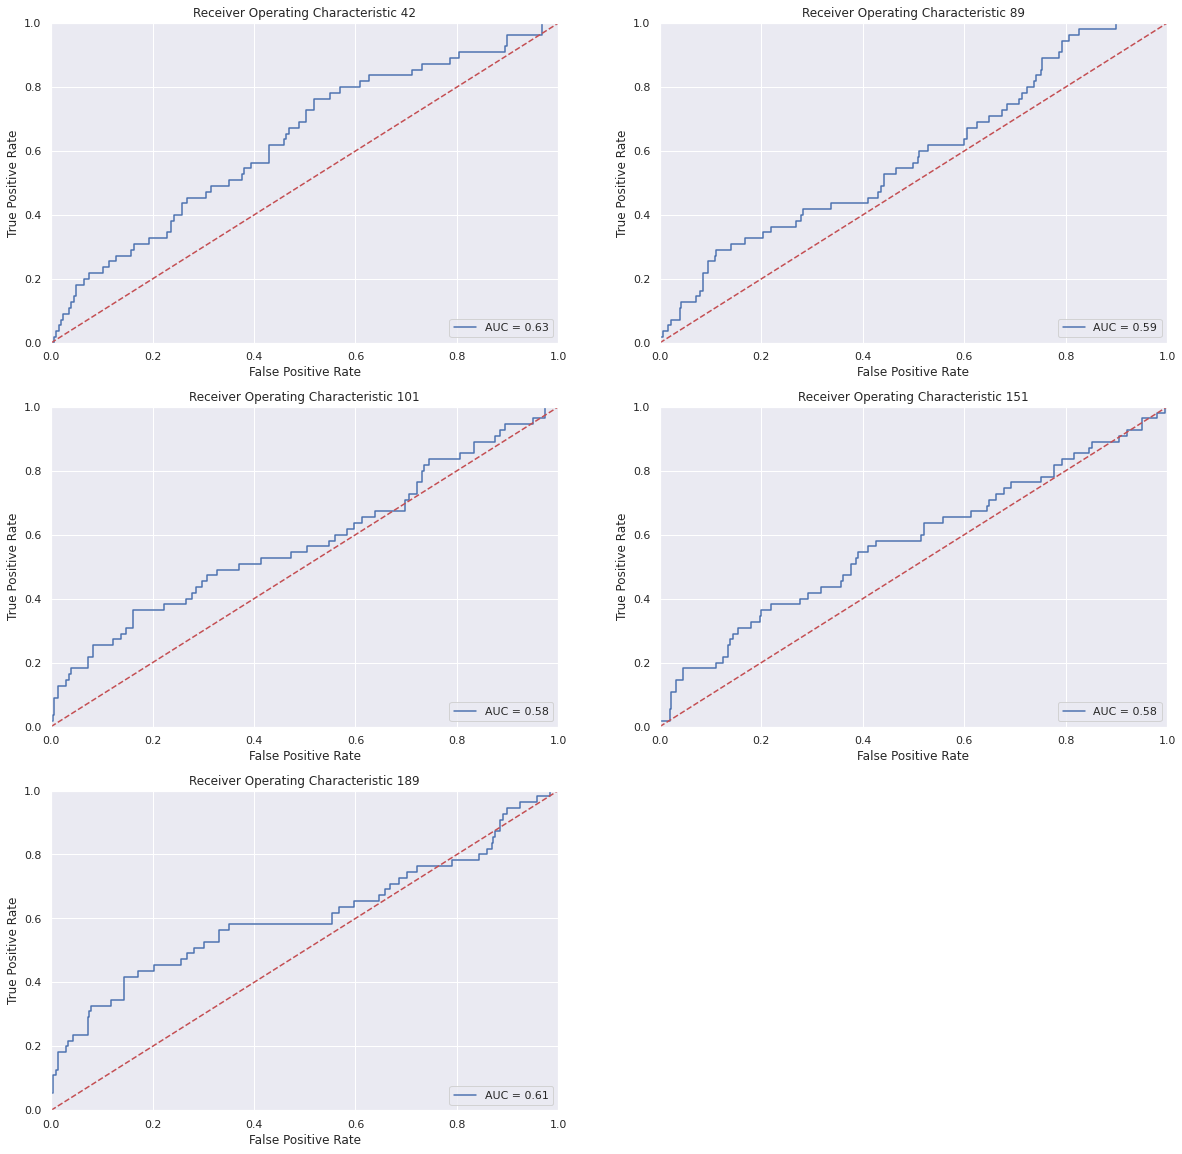

In [255]:
vis = ToolsVisualization()

vis.ROC_plot_total(Y_collection, outlierness_pred, 1)

**CONFUSION MATRIX**

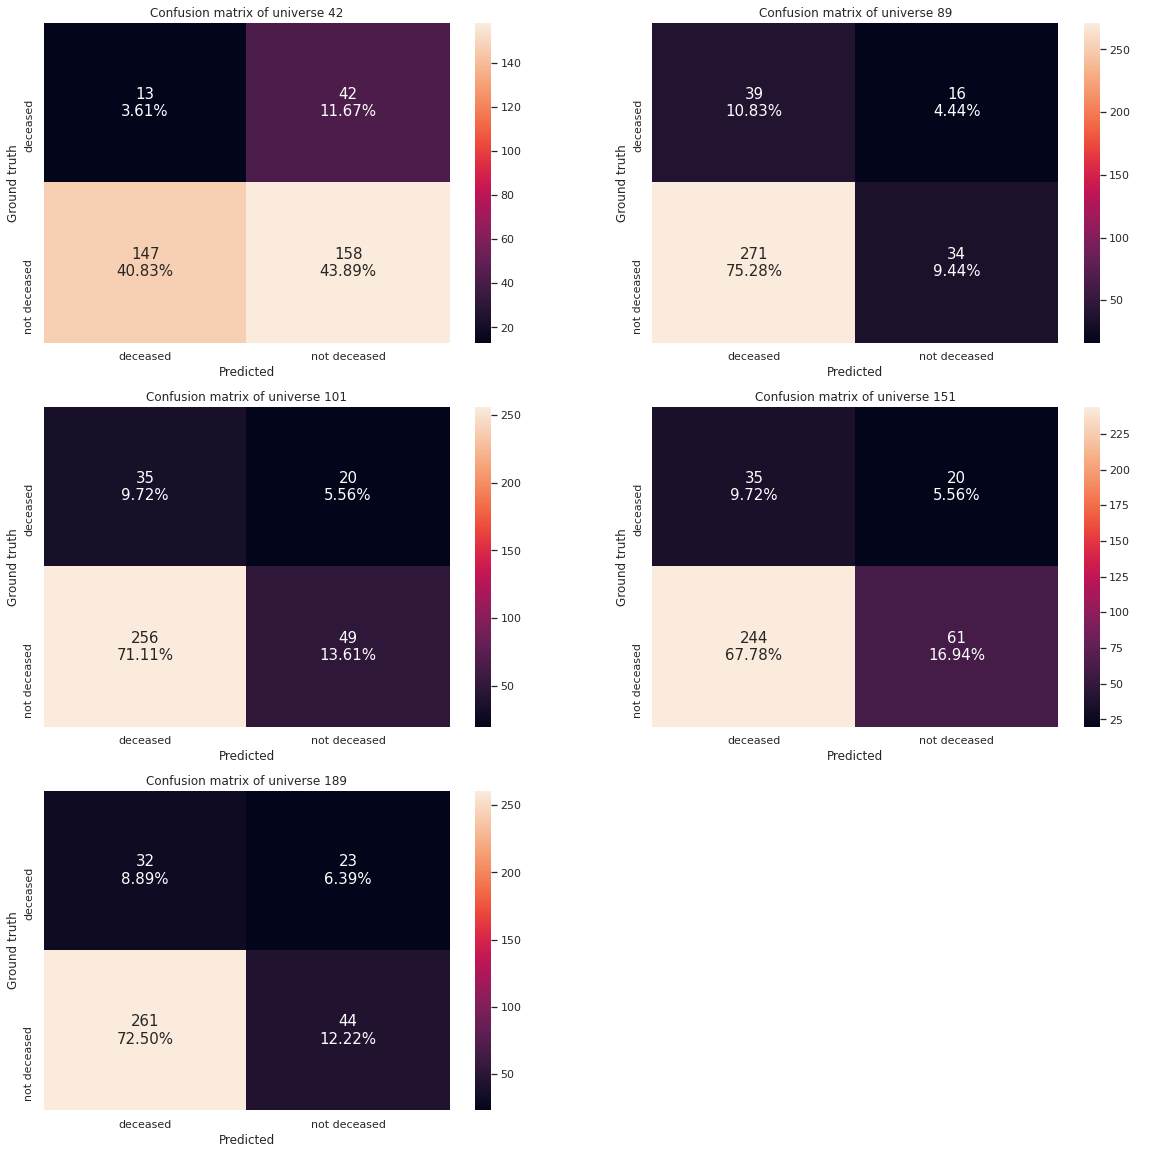

In [256]:
vis.confusion_matrix_plot_total(Y_collection, y_pred, [1, -1], normal='deceased',anomaly='not deceased')

**EVALUATION METRICS**

In [257]:
ev = tool.metric_evaluation(Y_collection, y_pred, outlierness_pred, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       13 42     |       39 16     |       35 20     |       35 20     |       32 23     |
| Negative        |     147 158     |      271 34     |      256 49     |      244 61     |      261 44     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.630*     |      0.586      |      0.579      |      0.575      |      0.607      |
| Accuracy        |      0.475*     |      0.203      |      0.233      |      0.267      |      0.211      |
| Precision       |      0.081      |      0.126*     |      0.120      |      0.125      |      0.109      |
| Sensitiv

# Appendix

In [50]:
r = np.random.RandomState(1234)

In [308]:
def outlierness_unsupervised_ap(outlier_score, normal=1, anomaly=-1, cutoff = -1, title = 'Outlierness represent'): 
# Visualize outlier-score (UNSUPERVISED WAY)
    ax = plt.figure(figsize=(10, 5), dpi=80).gca()
    plt.title(f'{title}')
    col = sns.color_palette("deep", n_colors=2)
    if (cutoff != -1):  
#         q = outlier_score.quantile(quantile)
        low_q = outlier_score.loc[outlier_score<cutoff]
        high_q = outlier_score.loc[outlier_score>=cutoff]
        sns.stripplot(x=low_q, ax = ax, color=col[0], label = f'Sample with low outlierness')
        sns.stripplot(x=high_q, ax = ax, color=col[1], label = f'Sample with high outlierness')
        plt.axvline(x=cutoff, color='g', linestyle='-', label=f'Cut-off value: {cutoff}')
        plt.xlabel('Outlierness')
        plt.legend()
    else:
        sns.stripplot(x=outlier_score, ax = ax, color = col[0])

#         plt.xticks(np.arange(min(outlier_score[universe]), max(outlier_score[universe])+1, 1.0))
    

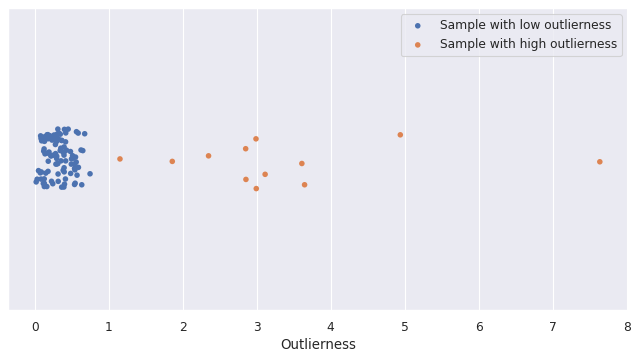

In [303]:
low = pd.Series(r.normal(loc=0.3, scale=0.2, size=(1,100))[0])
high = pd.Series(r.normal(loc=2, scale=2, size=(1,20))[0])
neg_idx = low.loc[low<0].index
low.drop(index = neg_idx, inplace=True)
neg_idx = high.loc[high<0].index
high.drop(index = neg_idx, inplace=True)

total = low.append(high)
outlierness_unsupervised_ap(total, cutoff = 1.1, title = "")


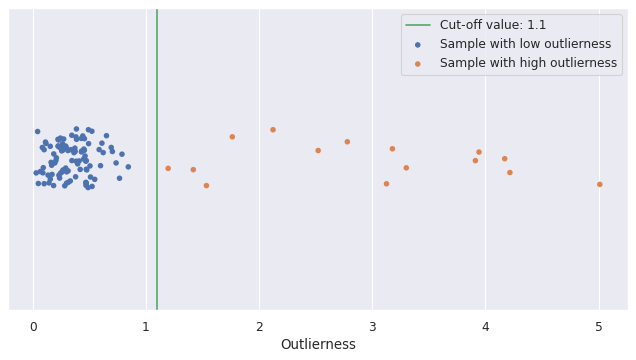

In [310]:
low = pd.Series(r.normal(loc=0.3, scale=0.2, size=(1,100))[0])
high = pd.Series(r.normal(loc=2, scale=2, size=(1,20))[0])
neg_idx = low.loc[low<0].index
low.drop(index = neg_idx, inplace=True)
neg_idx = high.loc[high<0].index
high.drop(index = neg_idx, inplace=True)

total = low.append(high)
outlierness_unsupervised_ap(total, cutoff = 1.1, title = "")
